Student: Nozomu Nakanishi
Student Id: 2020264
CA 2 - Big Data / Advanced Data Analytics - 17/11/23

Github: https://github.com/nozomu2020264/MSc-DA---CA2---2020264---10-11-23.git

This present notebook will present the practical section of the project by manipulating the data and applying time series analysis. 

- Importing the necessary libraries for the practical part.

In [160]:
from pyspark.sql import SparkSession # Imports Spark session.
import sparknlp # Imports SparkNLP (text processing).
# Imports data types and functions from PySpark.
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import to_date, to_timestamp, unix_timestamp, from_unixtime
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, expr, lit, regexp_replace, lower, split, size, length
from pyspark.sql.functions import when, corr, round
# Controls the storage level (memory and disk), to perform persist.
from pyspark import StorageLevel
import pandas as pd # Import Pandas.
import numpy as np # Numpy for matemathical purposes.
import matplotlib.pyplot as plt # Visualization library
import matplotlib.dates as mdates # Importing date features for visualization.
import seaborn as sns # Visualization library.
from sklearn.preprocessing import RobustScaler, PowerTransformer # Importing scalling tools.
from statsmodels.tsa.seasonal import seasonal_decompose # Imports seasonal decompose for time-series analysis.
from statsmodels.tsa.stattools import adfuller # Statistical approach for stationarity.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Auto-correlation plots for time-series analysis.
from statsmodels.tsa.ar_model import AutoReg # Imports Auto Regressive
from sklearn.metrics import mean_squared_error, mean_absolute_error # Imports metrics for evaluation.
from scipy import stats # Stats is for Shapiro test (normality).
from statsmodels.tsa.arima.model import ARIMA # ARIMA time series model.
from statsmodels.tsa.statespace.sarimax import SARIMAX# Imports SARIMA
import itertools # For hyper-parameter tunning.
import pmdarima as pm # Imports pmdarima to find optimal order values.
from pmdarima import auto_arima # Imports auto_arima for optimal parameters.

import warnings # Import warnings.
warnings.filterwarnings("ignore") # Surpress warnings.

- To avoid repetitions when commenting the code, codes such as .show() will not be commented. Because, more than 50% of them were used just for the Spark "lazyness" (to trigger the command).  

### Initializing Spark sessiong and Importing the dataset ProjectTweets.

In [2]:
# Initialize Spark Session with recommended settings for Spark NLP.
# Due to serialization problemes, Kyro Serializer will be used instead of the java. Too many serialization 
# errors encountered throughout the experimentation. 
spark = SparkSession.builder \
    .appName("ProjectTweets") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

- The manipulation of the dataset were possible on both MongoDB and Cassandra, however during the processing stage numeros serializations and pickled errors were being generated. Therefore, the project will be carried out importing the dataset from the local machine. 

<b>- Notebooks with the attempts using Cassandra and MongoDB are located in the GitHub repository provided.</b> 

In [3]:
# Defines the schema of the CSV file (ProjectTweets.csv) and adjust the field names and types for the dataframe.
tweetSchema = StructType([
    StructField("sequence", IntegerType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
])

# Imports the dataset in csv format.
df = spark.read.csv("file:///home/hduser/Desktop/CA2/ProjectTweets.csv", header=False, schema=tweetSchema)

In [4]:
df.show(5, truncate=False) # Display the dataset.

+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sequence|ids       |date                        |flag    |user           |text                                                                                                               |
+--------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0       |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|1       |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2       |1467810917|Mon Apr 06 22:19:53

In [5]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (1600000, 6)


- The dataframe called df has 6 columns and 1.6 millions of observations.

In the experimentation the columns that are important for the analysis are the dates and the text (tweets).

In [6]:
# Prints the df schema. 
df.printSchema()

# Which shows that the types of the data are ones set in previous steps.

root
 |-- sequence: integer (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



- It was observable that the dates have a pacific day time (PDT) and the present notebook it has a different time zone, thus setting the time zone to PDT.

In [7]:
# Sets the time zone to PDT, the same as the date column.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

In [8]:
# Creating a new column where the date has a format that is better to perform analysis and models.
# Features like the day of the week and time zone are not necessary. 
date_format = "EEE MMM dd HH:mm:ss zzz yyyy"
# Parses the date e creates a new column dates with a shorter format, but with the necessary data. 
df = df.withColumn("dates", from_unixtime(unix_timestamp("date", date_format)))
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|sequence|       ids|                date|    flag|           user|                text|              dates|
+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009-04-06 22:19:45|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|2009-04-06 22:19:49|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|2009-04-06 22:19:53|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|2009-04-06 22:19:57|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|2009-04-06 22:19:57|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009-04-06 22:20:00|
|       6|146781159

#### MISSING VALUES (TEXT COLUMN) AND DUPLICATES (TWITTER ID)

- The missing values will be searched through the tweets column, since the first objective is to extract the sentiment. 
- The duplicates will be searched through the twitter Id column, since is a unique identifier for each tweet, any duplicates will be further removed. 

In [9]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of missing values in 'text' column: 0


Number of duplicate ids: 1685


In [10]:
# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of duplicate ids: 1685


In [11]:
df = df.dropDuplicates(['ids'])

# Now you can check the count of the DataFrame to ensure duplicates have been removed.
print(f"Count after dropping duplicates: {df.count()}")

Count after dropping duplicates: 1598315


- No missing values were detected in the dataframe, however 1685 duplicates were found and removed. Reducing the number of observations to 1,598,315.

- Next step will drop columns that do not have purpose in the analysis and extraction.

In [12]:
# Drops the unnecessary columns.
df = df.drop("date", "ids", "user", "flag")
df.show()

+--------+--------------------+-------------------+
|sequence|                text|              dates|
+--------+--------------------+-------------------+
|       0|@switchfoot http:...|2009-04-06 22:19:45|
|       1|is upset that he ...|2009-04-06 22:19:49|
|       3|my whole body fee...|2009-04-06 22:19:57|
|       6|         Need a hug |2009-04-06 22:20:03|
|       8|@Tatiana_K nope t...|2009-04-06 22:20:05|
|       9|@twittera que me ...|2009-04-06 22:20:09|
|      12|@caregiving I cou...|2009-04-06 22:20:19|
|      15|@iamjazzyfizzle I...|2009-04-06 22:20:20|
|      18|@LettyA ahh ive a...|2009-04-06 22:20:31|
|      20|@alydesigns i was...|2009-04-06 22:20:37|
|      21|one of my friend ...|2009-04-06 22:20:38|
|      29|Meh... Almost Lov...|2009-04-06 22:21:04|
|      31|@alielayus I want...|2009-04-06 22:21:07|
|      33|@julieebaby awe i...|2009-04-06 22:21:11|
|      34|@HumpNinja I cry ...|2009-04-06 22:21:21|
|      35|ok I'm sick and s...|2009-04-06 22:21:20|
|      36|@c

- The column sequence was kept because it contains the original sequence of the dataframe, so in case of any shuffling the original sequence can be called. 

- Next stage will be performed the pre-processing of the tweets.  

# Pre-processing of the tweets and sentiment extraction.

- This step is separeted by two main lines of code, the first will normalized the tweets, by removing url, tags, mentions and character which has no meaning in sentiment extraction. The second is a pipeline from sparkNLP to generate and extract data that it is required to sentiment analysis over time and forecasting. 

- Both of the approaches will attempt to leverage the potential of Spark tools, such as the regex and the Natural Language Processing (NLP) tool, where it has numerous options from the simplest detection to deep learning. 

In [13]:
# Remove URLs
df = df.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
df = df.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
df = df.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
df = df.withColumn('text', lower(df['text']))

# Remove numbers from the "text" column
df = df.withColumn('text', regexp_replace(df['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
df = df.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
df = df.withColumn('text', regexp_replace(df['text'], r"[^\w\s]", ""))

# Shows the results of the normalization steps.
df.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                                    |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah                  |
| i dived many times for the ball managed to save   the rest go out of bounds                                                 |
|my whole body feels itchy and like its on fire                                                                               |
|need a hug                                                                                             

In [14]:
# Counts the entries with URLs.
url_count = df.filter(F.col("text").rlike("http(s)?://([\\w-]+\\.)+[\\w-]+(/[\\w- ./?%&=]*)?")).count()

# Counts the entries with HTML tags.
html_tags_count = df.filter(F.col("text").rlike("<[^>]+>")).count()

# Counts the entries with mentions (@username).
mentions_count = df.filter(F.col("text").rlike("@\\w+")).count()

print(f"Number of entries with URLs: {url_count}")
print(f"Number of entries with HTML tags: {html_tags_count}")
print(f"Number of entries with mentions: {mentions_count}")

Number of entries with URLs: 0
Number of entries with HTML tags: 0
Number of entries with mentions: 0


In [15]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 0


The last codes informs that: 
- The final format is satisfatory to apply NLP techniques; 
- Mentions, tags, html, etc, were successfuly removed after normalization;
- Also, no missing values were generated after the steps; 

### Natural Language Processing with SparkNLP library. 

The library chosen is based on a few factors. First, to extract the semtiment VADER approach , which is considered to be appropriate for social media content was attempt. However, erros related to out of memory and serialization led to the discard of the technique. And with many other options sparkNLP presented to be a good option, for memory efficiency and richness of NLP tasks. 
Overvall the choice of the library relies on: 
- It was built on top of Spark, thus is highly scalable and it is an appropriate choice for big dataframes, which is the case of this project, with more than a million tweets.
- It possess a vast number of operations, from the simplest to neural networks. The operations that are necessary to extract the data required can be achieved with only one library (memory effiency and consistency during transformations). 
- Pipeline, tasks can be perfomed with an optimized workflows through pipelines, reducing the number of codes to be called. 
- Pre-trained models, the library has models that are trained already that can be applied to other dataframes, in case of this project are, spell checker, word embeddings and sentiment extraction techniques will be used. 

The codes and usage for the techniques and models were obtain through the SparkNLP documentation / annotadors. <br>
1.  https://sparknlp.org/docs/en/concepts <br>
2.  https://sparknlp.org/docs/en/annotators

The pipeline is composed by eight operations: 

1. The first is to transform the tweets into a document format that is going to be required in the next stages;

2. Not only to maintain the original context, many other operations in the pipeline needs the text at a sentence level to perform at best, in the present case, the tokenizer onwards is mainly using this format;

- Language detector using a pre-trained model was performed, however it did not yield good results, removing the code from the pipeline.

3. Tokenization of the tweets, the next techniques required that the text inputs are separeted;

4. In social media content is known to have many type of misspellings and the sparkNLP provides a few options to correct it <b>(1)</b>. The pre-trained chosen model is NorvigSweeting model, although the choice was made due to memory constrains.<b>(2)</b> 
- The first pre-trained approach attempted was the Context Spell Checker, a noisy channel model spell algorithm. However, the machine used for project resulted in running of out memory, the machine is not powerful enough to perform this model. 

The attempts of the following stages were performed back and forth until a workflow was accepted by the machine capabilities. To avoid repetition, the steps 5, 6 and 7 were chosen by the machine capabilities, although the experiments of each one will be listed below. 

5. Embedding the words using the method Glove (100 dimensions) to vectorize the tokens. One of the simplest model provided by the annotators. Numerous trials were performed using different techniques, roBERta, BERT, Universal Sentence Encoder (USC), but all returned the same error, out of memory. In addition, the choice of the embedding technique suffered influence of the next steps.

6. Sentiment is extract at a sentence level, therefore the word embedding need to be to be transformed.

7. The model that will predict the sentiment of the tweets is the sentimentDL using the pre-trained model on the Glove imdb (movies reviews). 
- The model is not the ideal for this dataframe, however, models like the sentimentdl_use_twitter were attempted however it required a type of embedding that the present machine could not perform the UCS. <b>(3)</b> Therefore, the extraction and embedding approaches were chosen to aim the most suitable for text and accepted by the machine memory. 
- The threshold set to the model is 0.7, meaning that values above this will be labeled as positives and the values below the -0.7 will be considered negatives. Neutral sentiments will be labeled when the score falls between the two values.

<b>(1):</b>https://medium.com/john-snow-labs/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python-1cffa3250f57 <br>
<b>(2):</b>https://sparknlp.org/docs/en/annotators#contextspellchecker <br>
<b>(3):</b>https://sparknlp.org/2021/01/18/sentimentdl_use_twitter_en.html

In [16]:
from sparknlp.annotator import * # Imports the annotators (the techniques that will applied in the pipeline)
from sparknlp.base import *

# 1. Document assembler.
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence detector.
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenize the tweets.
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Context-aware Spell Checker
spellChecker = NorvigSweetingModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("corrected")

# 5. Word Embedding with Glove (100 dimentions).
embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
    .setInputCols(["sentence", "corrected"]) \
    .setOutputCol("embeddings")

# 6. Convert word embeddings to sentence embeddings, which is required for the sentiment extraction model. 
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

# 7. Use the SentimentDLModel compatible with GloVe embeddings (Threshold default value is 0.6).
sentiment_detector = SentimentDLModel.pretrained('sentimentdl_glove_imdb', 'en') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment") \
    .setThreshold(0.6) \

# 8. Finisher to convert annotations (the sentiments) to DataFrame columns.
finisher = Finisher() \
    .setInputCols(["sentiment"]) \
    .setOutputCols(["sentiment_result"]) \
    .setIncludeMetadata(True)

# Final pipeline with all stages
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    spellChecker,
    embeddings,
    sentence_embeddings,
    sentiment_detector,
    finisher  
])

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ \ ]spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
Download done! Loading the resource.
[ | ]

[ / ]

[ — ]

[ \ ]

[ | ]

[ / ]

[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ / ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
Download done! Loading the resource.
[OK!]
sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ — ]sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ \ ]Download done! Loading the resource.


[ | ]

[ / ]

2023-11-16 13:19:26.113780: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


- The pipeline will be applied and the results will be the addition of the columns with the corrected text (token format) and the sentiment (score and polarity) along with the metadata.
<br><br>
- The persist is being called in this line of code for a few reasons: 
1. Jupyter getting slow and memory issues starting to appear after the pipeline.
2. The dataframe suffered transformations up to this point and it will have more additional tasks after the pipeline, therefore to avoid the calculation of the workflow the technique will be applied. Note: cache was also attempted but the memory itself was not enough, thus sharing the dataframe between disk and memory.

In [17]:
# Apply the pipeline to the DataFrame
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
# Applies .persist() to save the transformations (df) in memory and disk.
df.persist(StorageLevel.MEMORY_AND_DISK)
df.count() # Code to trigger the persist.
df.show(truncate=False) # Display the results

+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|sequence|text                                                                                                                            |dates              |sentiment_result|sentiment_result_metadata                              |
+--------+--------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------+-------------------------------------------------------+
|68      |  not forever11 see you soon                                                                                                    |2009-04-06 22:23:28|[pos]           |[{sentence, 0}, {pos, 0.99131984}, {neg, 0.008680178}] |
|159     |oh  just got all my macheist  apps  sweet didnt get the es

In [20]:
df00 = df

After the pipeline a new data preparation has to be performed, because the results are not in the desired format.

The next steps will be performe due to:

- The sentiment column with the metadata does not have the overall score of the sentiment, just the sum of positive and negative score, thus the next line of code will calculate the final score. 

- The code will create a new column with dates in a new format timestamp (Year-Month-Day) in order to perform aggregations in a later stage. 

- The sentiment scores have too many decimals, which may increase the need of computational resources, thus the decimals after the whole number will be reduced to 3.

- Dropping columns that are not necessary anymore. 

In [21]:
# Creates a new column with only the Year, Month and the Day.
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))
df.select("dates", "daily_records").show()

+-------------------+-------------+
|              dates|daily_records|
+-------------------+-------------+
|2009-04-06 22:23:28|   2009-04-06|
|2009-04-06 22:30:50|   2009-04-06|
|2009-04-06 22:52:59|   2009-04-06|
|2009-04-06 23:01:14|   2009-04-06|
|2009-04-06 23:03:23|   2009-04-06|
|2009-04-06 23:18:16|   2009-04-06|
|2009-04-06 23:18:59|   2009-04-06|
|2009-04-06 23:23:03|   2009-04-06|
|2009-04-06 23:23:07|   2009-04-06|
|2009-04-06 23:32:47|   2009-04-06|
|2009-04-06 23:35:06|   2009-04-06|
|2009-04-06 23:35:10|   2009-04-06|
|2009-04-06 23:44:03|   2009-04-06|
|2009-04-06 23:53:53|   2009-04-06|
|2009-04-07 00:16:16|   2009-04-07|
|2009-04-07 00:32:13|   2009-04-07|
|2009-04-07 00:32:27|   2009-04-07|
|2009-04-07 00:38:06|   2009-04-07|
|2009-04-07 00:38:17|   2009-04-07|
|2009-04-07 00:48:22|   2009-04-07|
+-------------------+-------------+
only showing top 20 rows



In [22]:
# Extract positive and negative scores.
df = df.withColumn("positive_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'pos')[0]._2"))
df = df.withColumn("negative_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'neg')[0]._2"))

# Calculates sentiment score by subtracting the negative score from the positive score.
df = df.withColumn("sentiment_score", col("positive_score") - col("negative_score"))

# Show the resulting DataFrame with sentiment score
df.select("text", "sentiment_result", "sentiment_score").show()

+--------------------+----------------+-------------------+
|                text|sentiment_result|    sentiment_score|
+--------------------+----------------+-------------------+
|  not forever11 s...|           [pos]|        0.982639662|
|oh  just got all ...|       [neutral]|0.03298530000000005|
|crap i need more ...|           [neg]|       -0.994555624|
|i had a horrible ...|           [neg]|      -0.9991101201|
| hells to the no ...|           [pos]|         0.47807643|
|  the mint ones a...|           [pos]|          0.8148422|
| shut up you11i a...|           [pos]|       0.9971133619|
|i dont like lukew...|           [pos]|   0.99999982835387|
|got a great first...|           [pos]| 0.9999966465818001|
|would love to str...|           [pos]|    0.9999845035235|
|jade is looking f...|           [pos]|     0.999978249646|
| tweetfinder hate...|           [pos]|0.43312576999999997|
|im still at work ...|           [neg]|       -0.977214159|
|   is at  followers |           [pos]| 

In [24]:
# Round the sentiment_score to 3 decimal places
# Reducing the precision to three decimals can keep the precision and at the same making the column more memory friendly.
df = df.withColumn("sentiment_score", round(df["sentiment_score"], 3))

In [25]:
# The finisher returned the sentiment label in array, explode is being called to extract the labels. 
df = df.withColumn("sentiment_result", explode(df.sentiment_result))
df.show()

+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|sequence|                text|              dates|sentiment_result|sentiment_result_metadata|daily_records|positive_score|negative_score|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------------------+-------------+--------------+--------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|     [{sentence, 0}, {...|   2009-04-06|    0.99131984|   0.008680178|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|     [{sentence, 0}, {...|   2009-04-06|    0.51649266|    0.48350736|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|     [{sentence, 0}, {...|   2009-04-06|   0.002722176|     0.9972778|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|  

In [26]:
# After extracting all the desired data, unnecessary columns are going to be dropped.
df = df.drop("sentiment_result_metadata", "positive_score", "negative_score")
df.show()

+--------+--------------------+-------------------+----------------+-------------+---------------+
|sequence|                text|              dates|sentiment_result|daily_records|sentiment_score|
+--------+--------------------+-------------------+----------------+-------------+---------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|             pos|   2009-04-06|          0.983|
|     159|oh  just got all ...|2009-04-06 22:30:50|         neutral|   2009-04-06|          0.033|
|     493|crap i need more ...|2009-04-06 22:52:59|             neg|   2009-04-06|         -0.995|
|     598|i had a horrible ...|2009-04-06 23:01:14|             neg|   2009-04-06|         -0.999|
|  800822| hells to the no ...|2009-04-06 23:03:23|             pos|   2009-04-06|          0.478|
|  801106|  the mint ones a...|2009-04-06 23:18:16|             pos|   2009-04-06|          0.815|
|     868| shut up you11i a...|2009-04-06 23:18:59|             pos|   2009-04-06|          0.997|
|     918|

The commands of the previous cells presents that all the operations were succesfull. 

- A new column daily_records was successfull created. 
- The overall sentiment of the tweet also successfull extracted and calculated. 
- The last .show(), points that the reduction of long decimal numbers was successful.
- Also showing that the drop worked and the dataframe is ready to begin a exploratory analysis and followed by the time series analysis.

### Exploratory Data Analysis of tweets and scores.

In the exploratory section will be performed focusing on three main features of the dataframe, the time points (dates), the tweets and the sentiment scores.

In [27]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

+-------------+------+
|daily_records| count|
+-------------+------+
|   2009-05-13|  4055|
|   2009-06-25| 19663|
|   2009-05-01|  7691|
|   2009-06-15|109461|
|   2009-06-07| 96011|
|   2009-05-03| 35214|
|   2009-06-24|  6285|
|   2009-05-11|  4178|
|   2009-05-27|   837|
|   2009-04-17|  3076|
|   2009-06-20| 45282|
|   2009-04-20| 18405|
|   2009-06-22| 11986|
|   2009-04-21|  8572|
|   2009-05-23|   169|
|   2009-05-25|   169|
|   2009-06-01|109860|
|   2009-04-19| 27394|
|   2009-05-18| 36368|
|   2009-06-21| 16327|
+-------------+------+
only showing top 20 rows



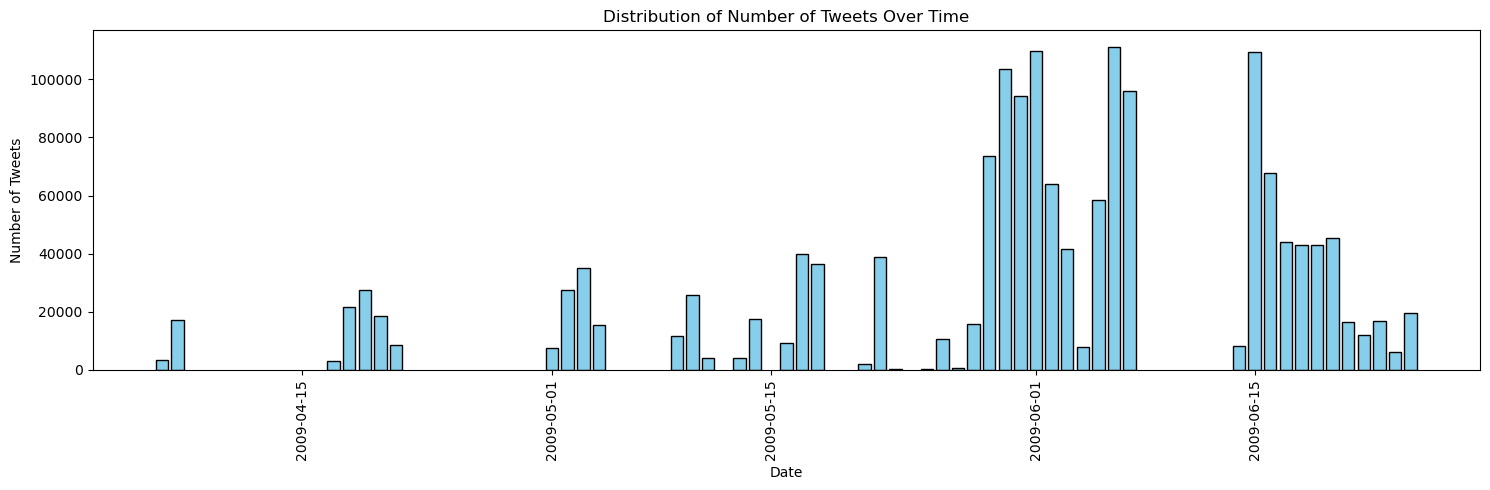

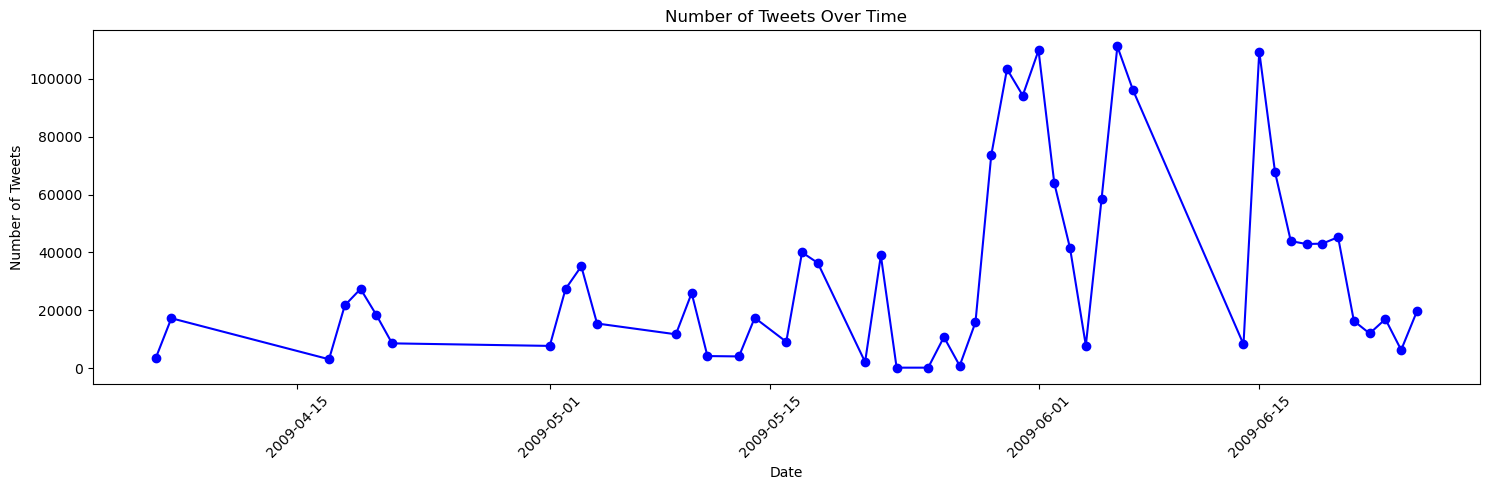

In [28]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
tweets_per_day_pd = tweets_per_day.toPandas()

# Sort the DataFrame based on the date for the line plot
tweets_per_day_pd.sort_values('daily_records', inplace=True)

# Plot the bar chart
plt.figure(figsize=(15, 5))
plt.bar(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)  # Rotate the dates for better readability if there are many bars
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Line plot of the number of tweets over time
plt.figure(figsize=(15, 5))
plt.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color='blue')
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


- The previous code shows that the number of tweets per day are not equal, presenting high variability between the days recorded (not normally distributed, based on the histogram). 
- Both the plots (bar and line) presents how the volume of tweets changes overtime, where the end of May until the middle of June have the highest number of tweets collected (more than 200K tweets).

Throughout the project it was noticed some gaps between the recorded days. Therefore, the next codes will identify what days are missing the recorded data range.

In [29]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (48, 2)


In [79]:
from pyspark.sql.functions import min, max

# Calculates the date range.
date_range = df.agg(min("daily_records").alias("min_date"), max("daily_records").alias("max_date"))
date_range.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2009-04-06|2009-06-25|
+----------+----------+



According to the previous codes:
- The range is from 2009-04-06 to 2009-06-25
- The total recorded days is 81.
- The number of days recorded is 48, thus the total missing days in the range is 33 days.

After identifying the missing days, which will have to imputed in order to perform time-series analysis, however a further EDA will help to decide a better strategy to address this gaps. 
- To further analyse the tweets the word count and text lenght will be generated. 

In [30]:
# Add a new column 'text_length' that contains the length of the 'text' column.
df = df.withColumn("text_length", length(df.text))

# Add a new column 'word_count' that contains the number of words in the 'text' column.
df = df.withColumn("word_count", size(split(df.text, "\s+")))

df.select("text_length", "word_count").show() # Display the word and char count.

+-----------+----------+
|text_length|word_count|
+-----------+----------+
|         28|         6|
|        123|        24|
|         29|         7|
|         82|        16|
|         37|        10|
|        119|        24|
|        111|        22|
|         29|         6|
|         57|        13|
|        118|        20|
|         34|         8|
|         91|        16|
|        128|        22|
|         17|         4|
|        124|        23|
|         67|        16|
|         37|         9|
|         60|        10|
|         56|        11|
|        102|        23|
+-----------+----------+
only showing top 20 rows



In [31]:
# Statistical features of the word and char count.
df.describe(["word_count", "text_length"]).show()

+-------+------------------+-----------------+
|summary|        word_count|      text_length|
+-------+------------------+-----------------+
|  count|           1595102|          1595102|
|   mean|13.599865713916728|  64.165568722251|
| stddev|6.7376460875575335|34.18022357508237|
|    min|                 1|                2|
|    max|                42|              179|
+-------+------------------+-----------------+



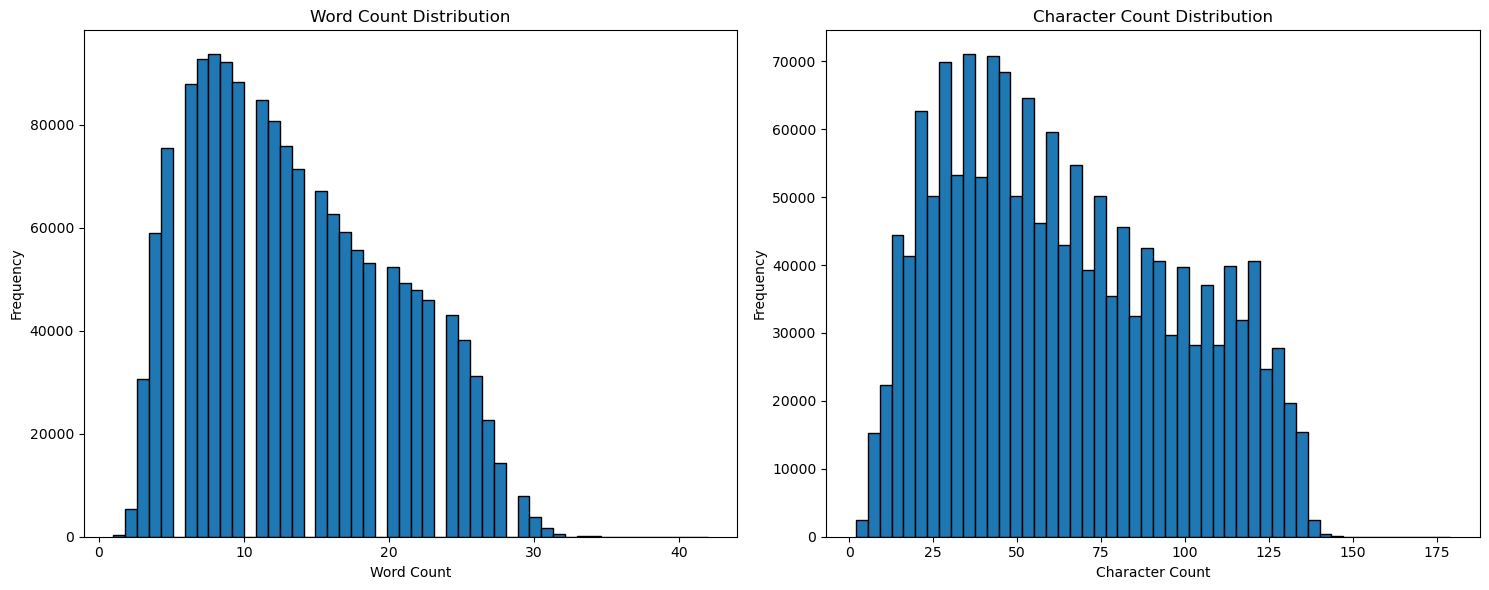

In [32]:
# Selects the word and char count columns.
word_char_df = df.select("word_count", "text_length").toPandas()

# Creates a figure with two subplots side by side.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Word Count Distribution.
axes[0].hist(word_char_df['word_count'], bins=50, edgecolor='black')
axes[0].set_title('Word Count Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot Character Count Distribution.
axes[1].hist(word_char_df['text_length'], bins=50, edgecolor='black')
axes[1].set_title('Character Count Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')

# Adjusts layout and display the plot.
plt.tight_layout()
plt.show()

In [33]:
# Calculates the correlation between the number of words and characters. 
correlation = df.stat.corr("word_count", "text_length")

print(f"The correlation coefficient between word count and character count is: {correlation}")

The correlation coefficient between word count and character count is: 0.9652185064975721


The descripte statistics and histograms of the word and character length informs that:

- Word count:
1. The shortest tweet has 1 word and the longest has 42.
2. The average of words per tweet is 13.6 and the StdDev is 6.75. Thus, with a considerable value in the StdDev, the tweets presents variability, but most of them are clusted around the mean value (average). 
3. The distribution plot shows that the majority of tweets are composed by 20 or less words. 
4. There are also longer tweets but they are less frequent, making the word count slightly right-skewed. 

- Character count: 
1. The shortest tweet has 2 char and the longest has 179. (Not surpassing the maximum amount of characters set by twitter at this time, which is 280).
2. The average of character in each tweet is 64, with a standard deviation of 34. Meaning that the based on the avg value the stddev is high (34), presenting a high variation around the average value. 

- Also the correlation between word and char are very high (0.96), and it is not surprising that if the number of words increases, consequently the text length will also increase.

- With some extreme values noticed in the .describe and the histograms, thus the boxplots will be performed to identify outliers, if there is any. 

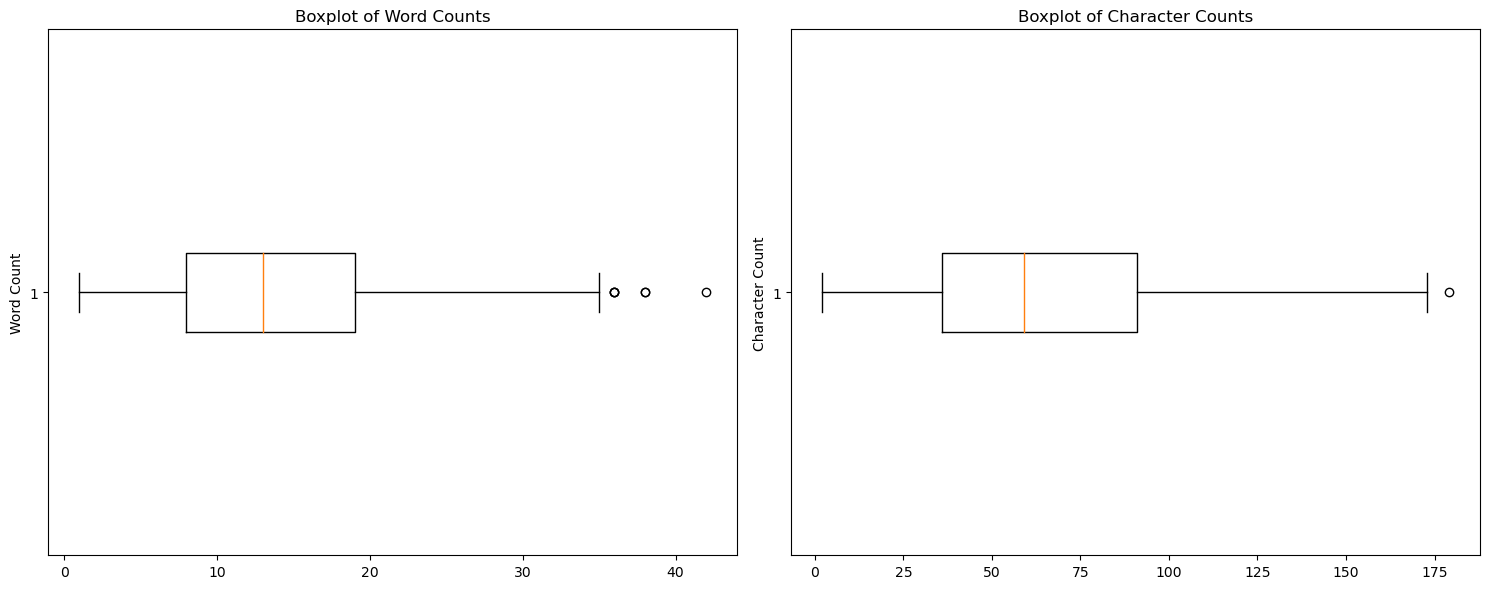

In [34]:
# Creates a figure with two subplots side by side for boxplots.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Boxplot for Word Count.
axes[0].boxplot(word_char_df['word_count'], vert=False) # Set to display horizontal boxplot.
axes[0].set_title('Boxplot of Word Counts')
axes[0].set_ylabel('Word Count')

# Plot Boxplot for Character Count.
axes[1].boxplot(word_char_df['text_length'], vert=False) # Set to display horizontal boxplot.
axes[1].set_title('Boxplot of Character Counts')
axes[1].set_ylabel('Character Count')

# Adjusts layout and display the plot.
plt.tight_layout()
plt.show()

- The boxplots of the number of character and words indicated the presence of outliers. However, users can express their opinions within a max range of characters, turning the outliers for this project a valid data point for analysis.  

- The next step will perform an aggregation to obtain the daily average of tweets word and characters count.

In [35]:
# Extract the daily records and the word count and ordering by date.
daily_word_count = df.groupBy("daily_records") \
    .agg(F.avg("word_count").alias("average_word_count"))

# Shows the resulting DataFrame.
daily_word_count.show()

+-------------+------------------+
|daily_records|average_word_count|
+-------------+------------------+
|   2009-05-13|13.517385943279901|
|   2009-06-25|14.155266236077912|
|   2009-05-01|13.502405408919516|
|   2009-06-15|13.517517654689799|
|   2009-06-07| 13.37701929987189|
|   2009-05-03|13.527716249219061|
|   2009-06-24|14.069212410501194|
|   2009-05-11|13.657252273815223|
|   2009-05-27|13.224611708482676|
|   2009-04-17|13.540637191157348|
|   2009-06-20|13.933439335718386|
|   2009-04-20|13.646291768541158|
|   2009-06-22|14.025946938094444|
|   2009-04-21| 13.78149790013999|
|   2009-05-23|13.680473372781066|
|   2009-05-25|13.911242603550296|
|   2009-06-01|13.590260331330784|
|   2009-04-19| 13.41344820033584|
|   2009-05-18|13.680515838099428|
|   2009-06-21|13.944080357689716|
+-------------+------------------+
only showing top 20 rows



In [36]:
# Creates a df with the daily average for the char count and ordering by date. 
daily_character_count = df.groupBy("daily_records") \
    .agg(F.avg("text_length").alias("average_character_count")) \
    .orderBy("daily_records")

# Show the resulting DataFrame.
daily_character_count.show()

+-------------+-----------------------+
|daily_records|average_character_count|
+-------------+-----------------------+
|   2009-04-06|      64.73397243858598|
|   2009-04-07|      65.22715419829635|
|   2009-04-17|      64.03836150845254|
|   2009-04-18|     63.206554807780954|
|   2009-04-19|      63.39782434109659|
|   2009-04-20|      64.69926650366749|
|   2009-04-21|      65.30121325244984|
|   2009-05-01|     63.832531530360164|
|   2009-05-02|      64.19498556339315|
|   2009-05-03|      63.88851025160447|
|   2009-05-04|      64.22819748606972|
|   2009-05-09|      62.71328492097394|
|   2009-05-10|      64.25258208725143|
|   2009-05-11|      64.36141694590714|
|   2009-05-13|      64.40887792848335|
|   2009-05-14|          65.1201171875|
|   2009-05-16|      62.78132543339917|
|   2009-05-17|      63.61345524494741|
|   2009-05-18|      64.95430048394192|
|   2009-05-21|      63.88024516737388|
+-------------+-----------------------+
only showing top 20 rows



- Also looking at the distribution plot where most of the tweets are allocated between word level (5-15) and char level (50-65), the resulted daily averages falls under the expected range. However, a similiar average was not expected. 

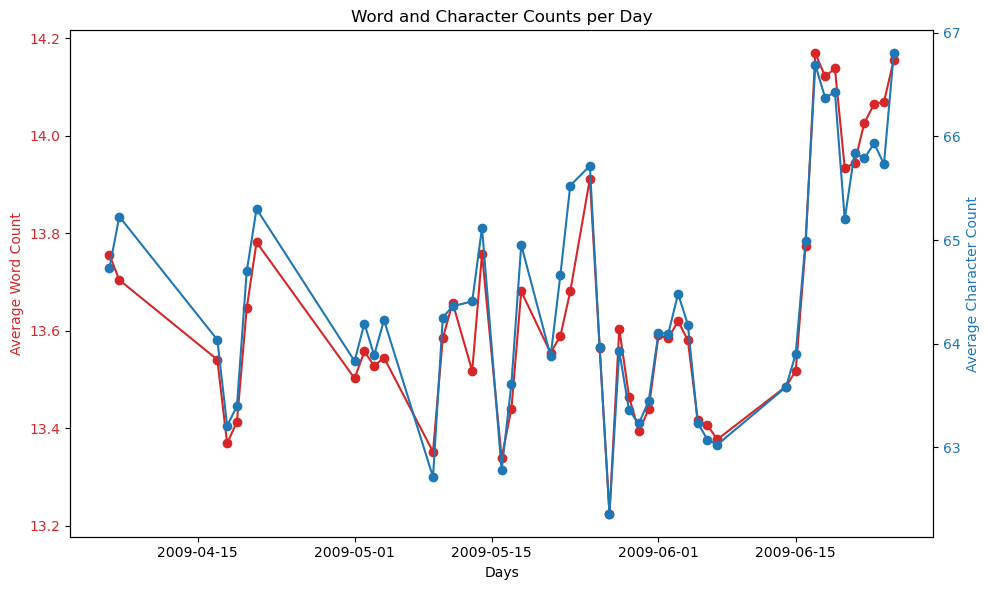

In [37]:
# Convert to Pandas DataFrames
daily_word_count_pd = daily_word_count.toPandas()
daily_character_count_pd = daily_character_count.toPandas()

# Sort Pandas DataFrames by 'daily_records'
daily_word_count_pd = daily_word_count_pd.sort_values('daily_records')
daily_character_count_pd = daily_character_count_pd.sort_values('daily_records')

# Plotting the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Average Word Count', color=color)
ax1.plot(daily_word_count_pd['daily_records'], daily_word_count_pd['average_word_count'], color=color, marker='o', label='Average Word Count')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Character Count', color=color)
ax2.plot(daily_character_count_pd['daily_records'], daily_character_count_pd['average_character_count'], color=color, marker='o', label='Average Character Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Word and Character Counts per Day')
plt.tight_layout()
plt.show()

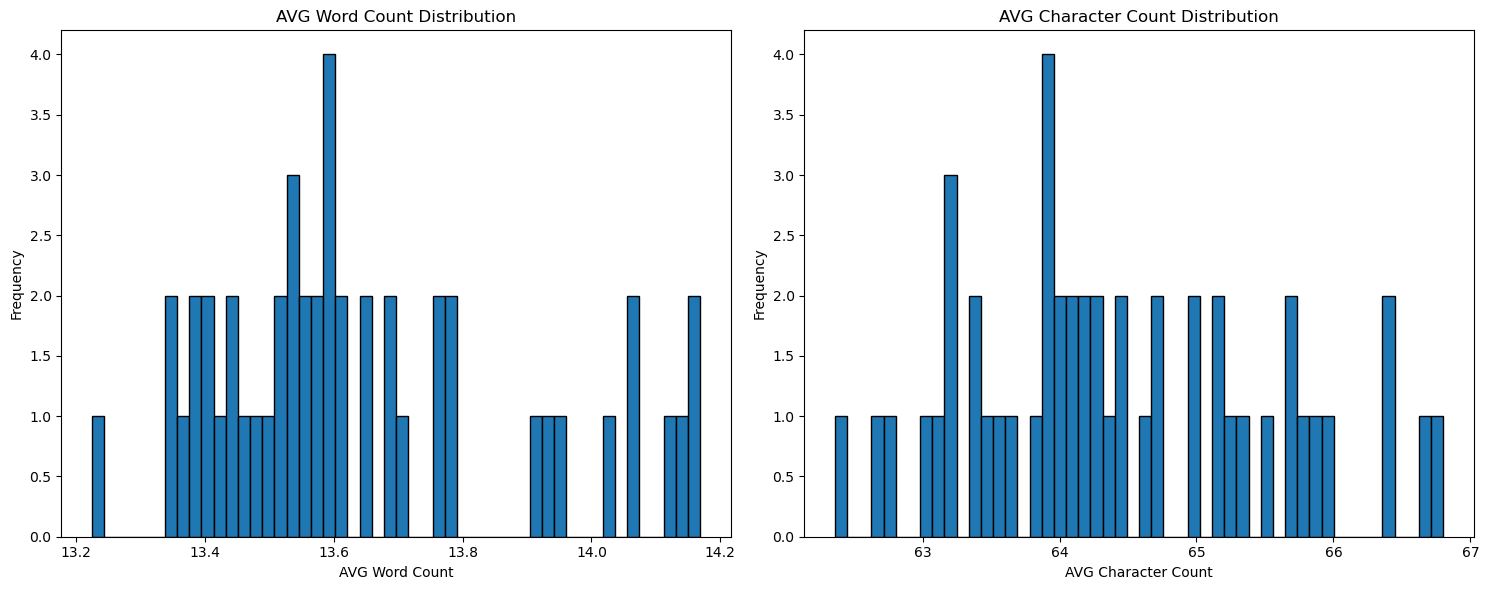

In [38]:
# Creates a figure with two subplots side by side.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Word Count Distribution.
axes[0].hist(daily_word_count_pd ['average_word_count'], bins=50, edgecolor='black')
axes[0].set_title('AVG Word Count Distribution')
axes[0].set_xlabel('AVG Word Count')
axes[0].set_ylabel('Frequency')

# Plot Character Count Distribution.
axes[1].hist(daily_character_count_pd['average_character_count'], bins=50, edgecolor='black')
axes[1].set_title('AVG Character Count Distribution')
axes[1].set_xlabel('AVG Character Count')
axes[1].set_ylabel('Frequency')

# Adjusts layout and display the plot.
plt.tight_layout()
plt.show()

- The line plot with the word and character count per day follow the logical where the number of characters tend to follow the number of words. 
- Only a few days where user posted longer tweets but with less characters.
- Also looking at the distribution plot where most of the tweets are allocated between word level (5-15) and char level (50-65), the resulted daily averages falls under the expected range. However, a similiar average was not expected. 

### EDA Sentiment Label and Scores

In [39]:
# Calculates the total number of tweets.
total_count = df.count()

# Group by the 'sentiment' column and count how many.
frequency_df = df.groupBy("sentiment_result").count()

# Shows the frequency of each sentiment. 
frequency_df.show()

+----------------+------+
|sentiment_result| count|
+----------------+------+
|             pos|851093|
|             neg|702943|
|         neutral| 41066|
+----------------+------+



- The sentimentDL technique resulted in the majority of positive tweets 800K+, followed by the negatives with 700K+ and Neutral with 41K+. The results are quite imbalanced when comparing the neutrals with other sentiments. 
- The next codes will analyse the statistics and distribution of sentiment scores. 
- The analysis of the next three codes will be written all together after the commands.

In [40]:
# Sentiment scores descriptive statistics.
df.describe("sentiment_score").show()

+-------+-------------------+
|summary|    sentiment_score|
+-------+-------------------+
|  count|            1595102|
|   mean|0.09422252996986986|
| stddev| 0.9290872774505394|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [41]:
# Defines bin ranges.
bin_ranges = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Creates a new column for the bins.
# Creates bin conditions using a function.
bin_conditions = when(df.sentiment_score <= bin_ranges[0], str(bin_ranges[0]))
for i in range(1, len(bin_ranges)):
    bin_conditions = bin_conditions.when((df.sentiment_score > bin_ranges[i - 1]) & (df.sentiment_score <= bin_ranges[i]), str(bin_ranges[i]))

# Adds a default case if needed.
bin_conditions = bin_conditions.otherwise(str(bin_ranges[-1]))

# Apply the binning.
df_with_bins = df.select("sentiment_score").withColumn("score_bin", bin_conditions)

# Group by the bins and the count.
histogram_data = df_with_bins.groupBy("score_bin").count().collect()

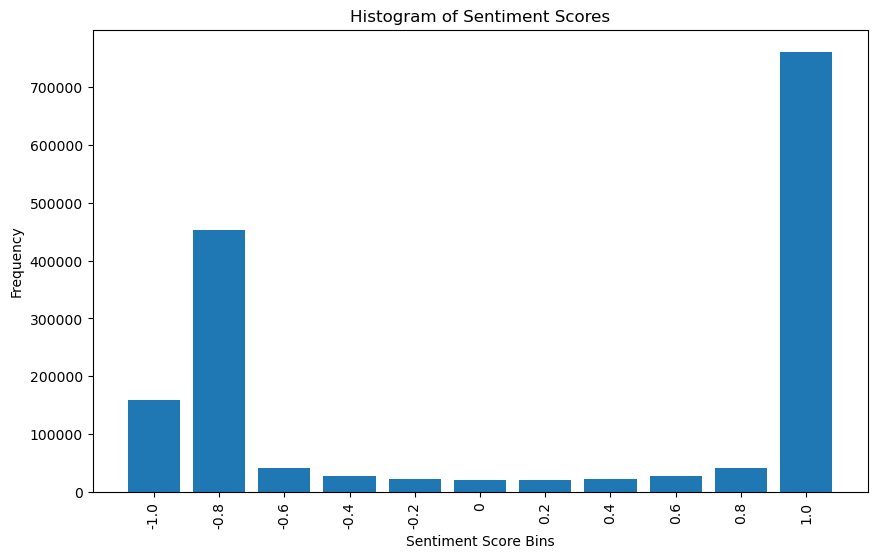

In [42]:
# Converts the score_bin from a range string to the lower bound for sorting.
histogram_data_sorted = sorted(histogram_data, key=lambda x: float(x['score_bin'].split(' to ')[0]))

# Extracts the bins and counts again, which should be sorted.
bins_sorted = [row['score_bin'] for row in histogram_data_sorted]
counts_sorted = [row['count'] for row in histogram_data_sorted]

# Plot the histogram with the sorted bins.
plt.figure(figsize=(10, 6))
plt.bar(range(len(counts_sorted)), counts_sorted, align='center')  # Use numerical x-axis.
plt.xticks(range(len(bins_sorted)), bins_sorted, rotation=90)  # Add bin labels as x-tick labels.
plt.xlabel('Sentiment Score Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()


The previous codes shows that:
- The range of the scores are between -1 and 1 (as expected from the model).
- The sentiment scores have the average of 0.09, informing that the overall sentiment of the dataframe is slightly positive. 
- The StdDev of 0.929 shows that the scores will present a high variability and based on the range it will vary between the extreme points. 
- Due to its characteristics the distribution do not present any skewness, but rather a big difference between extreme "opinions" and neutral tweets. 
- By investigating the histogram where it shows that most of the values are located at the extremes (Bimodal distribution) and because of the mathematical operation the average will tend to the center.
<br><br>

Further analysis will be perform on a daily basis, thus the next step will aggregate to generate the overall sentment of the day. 
- The distribution of tweets are unequal among the recorded days. Therefore, different techniques will be attemped to chose the most appropriate to continue.  
- Three approaches will be applied and later discussed, using median, mean and weighted averaged.

In [43]:
# Calculate the median sentiment score for each day
daily_median_sentiment = df.groupBy('daily_records').agg(F.expr('percentile_approx(sentiment_score, 0.5)').alias('median_sentiment'))
daily_median_sentiment.show()

+-------------+----------------+
|daily_records|median_sentiment|
+-------------+----------------+
|   2009-05-13|           0.722|
|   2009-06-25|          -0.711|
|   2009-05-01|           0.757|
|   2009-06-15|           0.716|
|   2009-06-07|           0.825|
|   2009-05-03|           0.755|
|   2009-06-24|            -0.6|
|   2009-05-11|           0.607|
|   2009-05-27|           0.501|
|   2009-04-17|            0.83|
|   2009-06-20|           -0.59|
|   2009-04-20|           0.743|
|   2009-06-22|          -0.561|
|   2009-04-21|           0.751|
|   2009-05-23|           0.785|
|   2009-05-25|           0.956|
|   2009-06-01|           0.733|
|   2009-04-19|           0.802|
|   2009-05-18|           0.764|
|   2009-06-21|          -0.522|
+-------------+----------------+
only showing top 20 rows



In [44]:
# For weighted average, calculates the mean sentiment and count of tweets for each day.
daily_sentiment = df.select("sequence", "sentiment_score", "daily_records").groupBy('daily_records').agg(
    F.avg('sentiment_score').alias('average_sentiment'),
    F.count('sequence').alias('tweet_count'))

# Adds a normalized weight for each day based on volume of tweets.
max_tweets = daily_sentiment.agg(F.max('tweet_count')).first()[0]
daily_sentiment = daily_sentiment.withColumn('weight', F.col('tweet_count') / max_tweets)

# Calculates the weighted average sentiment.
weighted_average_sentiment = daily_sentiment.withColumn('weighted_sentiment', F.col('weight') * F.col('average_sentiment'))

weighted_average_sentiment.show() # Display the results.

+-------------+--------------------+-----------+--------------------+--------------------+
|daily_records|   average_sentiment|tweet_count|              weight|  weighted_sentiment|
+-------------+--------------------+-----------+--------------------+--------------------+
|   2009-05-13| 0.11092133168927258|       4055| 0.03645337025117316|0.004043456372822239|
|   2009-06-25|-0.12003895641560298|      19663|  0.1767651342167245|-0.02121870224203...|
|   2009-05-01| 0.12565011051878816|       7691| 0.06914004207195383|0.008687453927614662|
|   2009-06-15|  0.1129580946638528|     109461|  0.9840252431722972| 0.11115361656987713|
|   2009-06-07| 0.14282613450542117|      96011|  0.8631133245833258| 0.12327513979035933|
|   2009-05-03| 0.12381229056625218|      35214| 0.31656448336000287|0.039194573796724176|
|   2009-06-24|-0.09241416070007953|       6285| 0.05650047645588738|-0.00522144411082...|
|   2009-05-11| 0.09505241742460507|       4178| 0.03755910749923587|0.003570083964112...|

In [45]:
# Collects the data.
daily_median_sentiment_data = daily_median_sentiment.sort('daily_records').collect()

# Extracts dates and median sentiments to plot the figure.
dates = [row['daily_records'] for row in daily_median_sentiment_data]
median_sentiments = [row['median_sentiment'] for row in daily_median_sentiment_data]

# Collects the data.
weighted_average_sentiment_data = weighted_average_sentiment.sort('daily_records').collect()

# Extracts dates, weights and averages to plot the figure.
dates = [row['daily_records'] for row in weighted_average_sentiment_data]
weighted_avg_sentiments = [row['weighted_sentiment'] for row in weighted_average_sentiment_data]
avg_sentiments = [row['average_sentiment'] for row in weighted_average_sentiment_data]

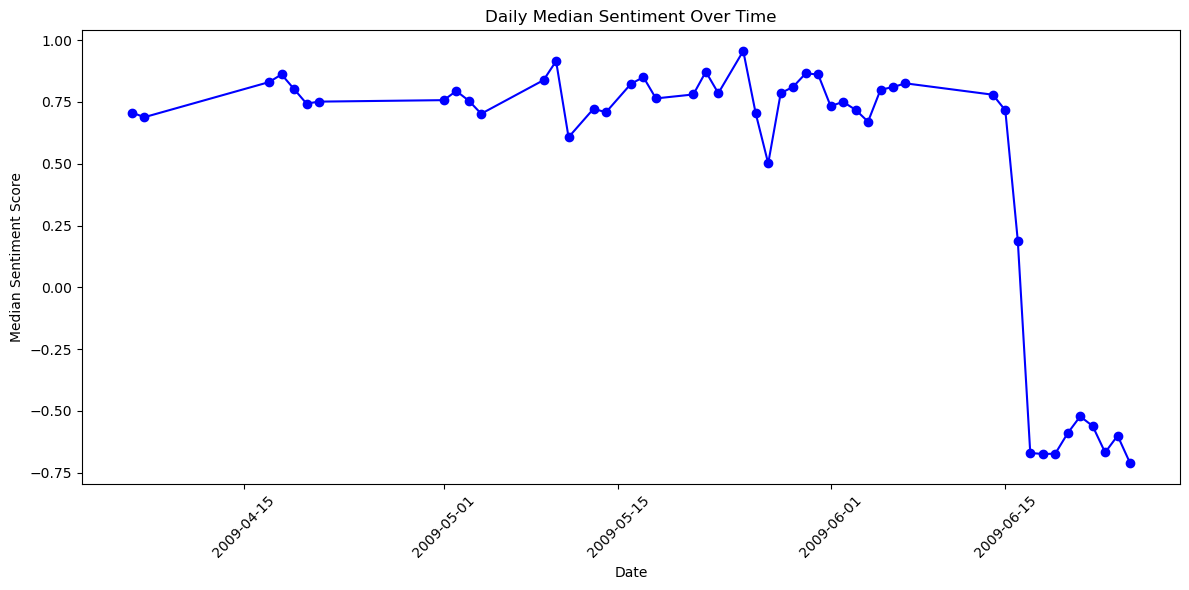

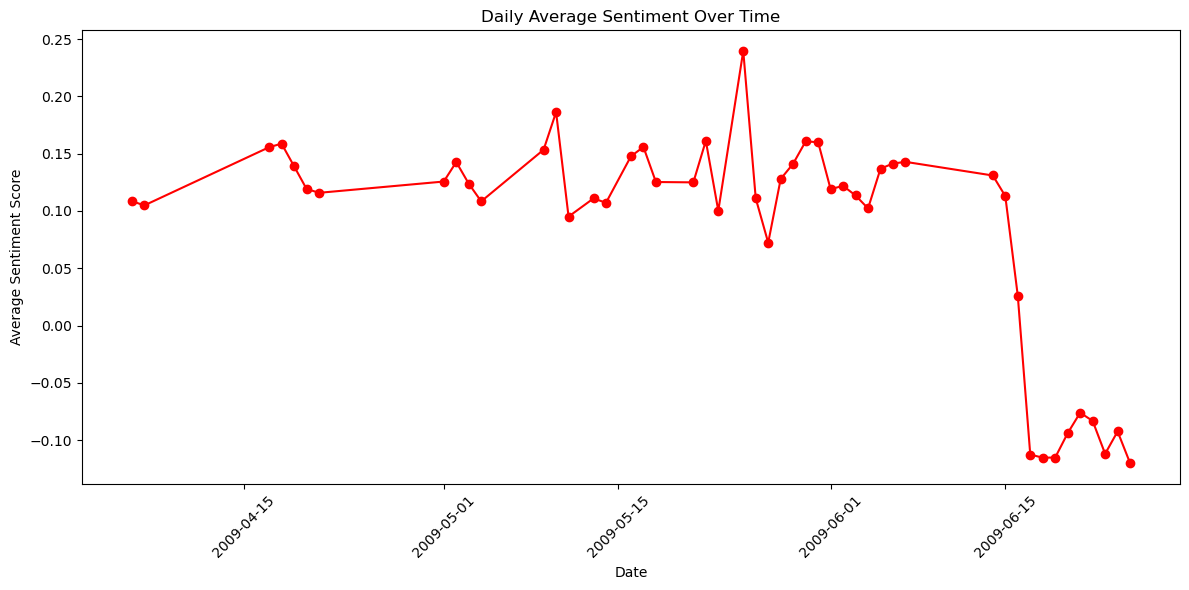

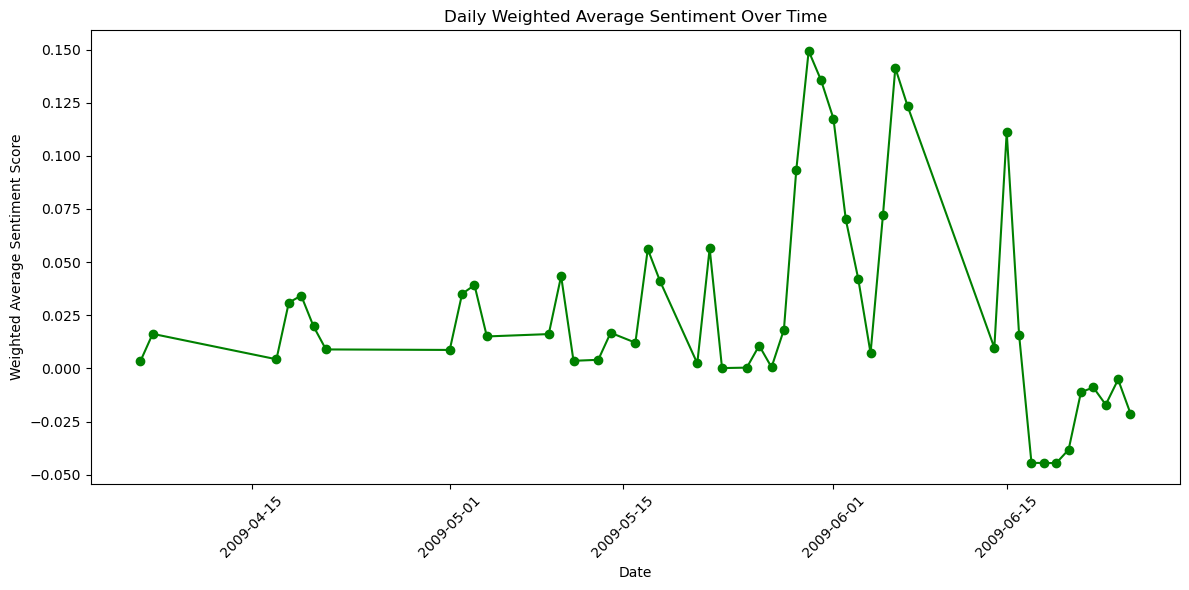

In [46]:
# Plot the time series using median.
plt.figure(figsize=(12, 6))
plt.plot(dates, median_sentiments, marker='o', linestyle='-', color='blue')
plt.title('Daily Median Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Median Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Plot the time series using average,
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_sentiments, marker='o', linestyle='-', color='red')
plt.title('Daily Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Plot the time series using weighted average.
plt.figure(figsize=(12, 6))
plt.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color='green')
plt.title('Daily Weighted Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

Three techniques applied to obtain the overall sentiment of the day resulted in the following insights.
- By using average or median it yielded a similar pattern, although having different representation scales. 
- By using weighted average it presented a different format, taking in to account the weights based on the volume of tweets posted per day.

The chosen approach to aggregate the daily sentiment score will be performed using the weighted average: 
- More data available on these days, presenting not only more samples, but with different scale of moods and polarities. 
- Days with few tweets (hundreds), can have numerous extreme scores which can lead to skewness. But days with more tweets (+200K) may represent a day  that something important was happening that day.

The chosen approach has a direct affect on the line pattern, which probably will be strongly correlated to the volume of tweets.

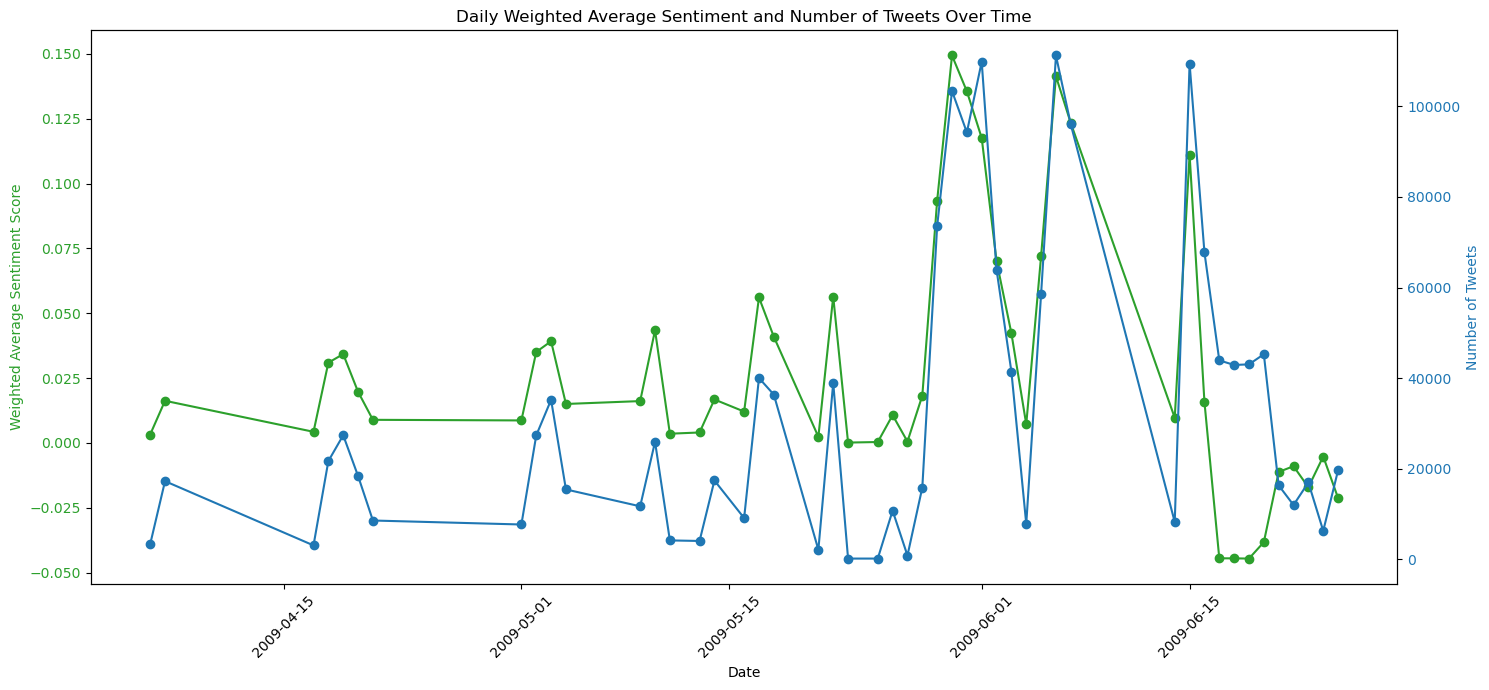

In [47]:
# Creates a figure and a single subplot.
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plots the weighted average sentiment over time on the primary y-axis.
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Sentiment Score', color=color)
ax1.plot(dates, weighted_avg_sentiments, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Plots the volume of tweets over time in the second x-axis.
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Tweets', color=color)  
ax2.plot(tweets_per_day_pd['daily_records'], tweets_per_day_pd['count'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout.
plt.title('Daily Weighted Average Sentiment and Number of Tweets Over Time')
fig.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping.
plt.show()

- As suspected and mostly because of the technique characteristics, most of the sentiment scores tend to follow the volume of the tweets. 

The dataframe to be used in the time seties analysis contains the date of the record (daily_records), the weight (based on volume of tweets) and the the weighted sentiment score. 

### Time-Series Analysis using daily overall sentiment score. 

- The analysis will be carried out using the days as the time points and the weighted sentiment. 

In [48]:
# Drops the columns that are no longer needed for the next stages.
df_daily_sent = weighted_average_sentiment.drop("average_sentiment", "tweet_count")

# Reducing the precision to 3 and 5 decimals can keep the precision and at the same making the column 
# more memory friendly.
df_daily_sent = df_daily_sent.withColumn("weighted_sentiment", round(df_daily_sent["weighted_sentiment"], 3))
df_daily_sent = df_daily_sent.withColumn("weight", round(df_daily_sent["weight"], 5))
df_daily_sent.show()

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-05-13|0.03645|             0.004|
|   2009-06-25|0.17677|            -0.021|
|   2009-05-01|0.06914|             0.009|
|   2009-06-15|0.98403|             0.111|
|   2009-06-07|0.86311|             0.123|
|   2009-05-03|0.31656|             0.039|
|   2009-06-24| 0.0565|            -0.005|
|   2009-05-11|0.03756|             0.004|
|   2009-05-27|0.00752|             0.001|
|   2009-04-17|0.02765|             0.004|
|   2009-06-20|0.40707|            -0.038|
|   2009-04-20|0.16546|              0.02|
|   2009-06-22|0.10775|            -0.009|
|   2009-04-21|0.07706|             0.009|
|   2009-05-23|0.00152|               0.0|
|   2009-05-25|0.00152|               0.0|
|   2009-06-01|0.98761|             0.118|
|   2009-04-19|0.24626|             0.034|
|   2009-05-18|0.32694|             0.041|
|   2009-06-21|0.14678|            -0.011|
+----------

- With gaps identified in early stages (33 NA), the following codes will add the missing days so the imputation of sentiment scores can be performed. Thus, the days that are not present in the dataframe will be added.

In [49]:
# Creates a DataFrame with a range of dates with interval of one day.
date_df = spark.sql("SELECT explode(sequence(to_date('2009-04-06'), to_date('2009-06-25'), interval 1 day)) as daily_records")
date_df.show()

+-------------+
|daily_records|
+-------------+
|   2009-04-06|
|   2009-04-07|
|   2009-04-08|
|   2009-04-09|
|   2009-04-10|
|   2009-04-11|
|   2009-04-12|
|   2009-04-13|
|   2009-04-14|
|   2009-04-15|
|   2009-04-16|
|   2009-04-17|
|   2009-04-18|
|   2009-04-19|
|   2009-04-20|
|   2009-04-21|
|   2009-04-22|
|   2009-04-23|
|   2009-04-24|
|   2009-04-25|
+-------------+
only showing top 20 rows



In [50]:
# Joins with the existing DataFrame to add the "gaps".
result_df = date_df.join(df_daily_sent, "daily_records", "left_outer") # Join is based on the dates.
result_df.show() # Shows the result.

+-------------+-------+------------------+
|daily_records| weight|weighted_sentiment|
+-------------+-------+------------------+
|   2009-04-11|   null|              null|
|   2009-04-17|0.02765|             0.004|
|   2009-04-20|0.16546|              0.02|
|   2009-04-15|   null|              null|
|   2009-04-16|   null|              null|
|   2009-04-13|   null|              null|
|   2009-04-21|0.07706|             0.009|
|   2009-04-19|0.24626|             0.034|
|   2009-04-25|   null|              null|
|   2009-04-14|   null|              null|
|   2009-04-26|   null|              null|
|   2009-04-07|0.15514|             0.016|
|   2009-04-08|   null|              null|
|   2009-04-18|0.19502|             0.031|
|   2009-04-22|   null|              null|
|   2009-04-24|   null|              null|
|   2009-04-06|0.03001|             0.003|
|   2009-04-12|   null|              null|
|   2009-04-23|   null|              null|
|   2009-04-09|   null|              null|
+----------

In [51]:
# Find the count of missing values in the 'text' column
missing_values_count = result_df.filter(result_df.weighted_sentiment.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 33


- The number of missing values matches the number of "gaps" expected.

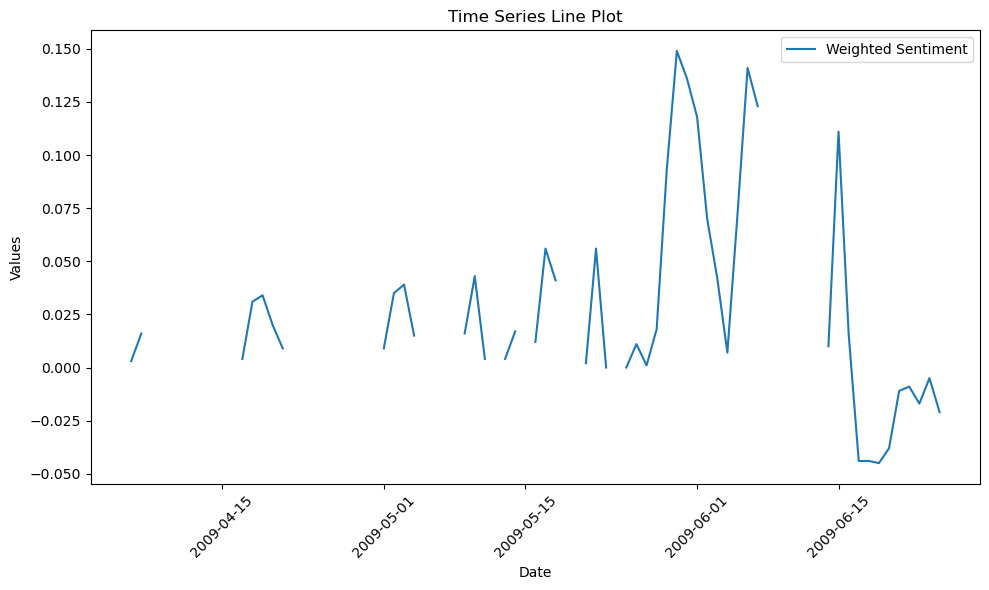

In [52]:
# Order the DataFrame by date
result_df = result_df.orderBy("daily_records")

# Convert to Pandas DataFrame for plotting
pandas_df = result_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment'], label='Weighted Sentiment')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The previous code displayed the line plot showing the gaps in the dataframe:
- There are more missing data at the start of the period. 
- The plot is important to have as a reference to check the perfomance of the techniques applied. 

- The dataframe became much smaller compared to the original set 1.6 million to 81 observations, thus Pandas format will be used also for visualization purpose.

In [53]:
# Resets the index to the date column.
pandas_df.reset_index(inplace=True)

# Creating a copy to use as reference.
df_og = result_df.toPandas()

### Imputation techniques attempted to address "gaps".

- To perform time series analysis all the data points in the range has to be filled with score sentiment.
- To fill all the missing days, different approaches will be applied and evaluated through its statistical characteristics. 
- In total 4 techniques will be tested Linear Interpolation, Cubic Interpolation, Exponential Moving Average (EMA) and Rolling Weighted Average (Volume of tweets). 
- The coding to apply the imputation will be called and the analysis will be carried out comparing the four techniques at the same time.


#### Linear Interpolation. 

In [54]:
# Apply linear interpolation.
pandas_df['weighted_sentiment_linear_interp'] = pandas_df['weighted_sentiment'].interpolate(method='linear')

#### Exponential Moving Average (EMA).

1. A technique that uses the value of alpha to help smooth short term functuations, which the can be observed in the scores overtime. 
2. To avoid numerous figures and cells with the same code, only one EMA code is going to be displayed.

- Alpha values tested: ranges from 0.1 to 1, however all the figures resulted in the same characteristics as observerd in the next figure.

In [55]:
# Defines the EMA function to apply in the all series.
def ema_imputation(series, alpha):
    imputed_series = series.copy()
    missing_indices = series.isnull()

    for i in range(len(series)):
        if i == 0:
            if missing_indices[i]:
                # Handle first element if it's missing
                imputed_series[i] = 0  # or some other default value
        else:
            if missing_indices[i]:
                # Use EMA formula to impute missing values
                imputed_series[i] = (1 - alpha) * imputed_series[i - 1]
            else:
                # If not missing, keep the original value
                imputed_series[i] = series[i]

    return imputed_series

In [56]:
# Creating a copy to use for EMA.
pandas_df2 = result_df.toPandas()

# Choose the alpha value (smoothing factor).
alpha = 0.5 

# Apply EMA imputation to the 'weighted_sentiment' column.
pandas_df2['imputed_weighted_sentiment'] = ema_imputation(pandas_df2['weighted_sentiment'], alpha)

#### Rolling Weighted Average

- The weights that are going to be used are from the volume of tweets, the same value used to aggregate the tweets to daily averages.
- To apply the rolling weighted average the weights have to be filled, thus the median approach will be selected to perform this.
- The mean The mean provided a higher value (aprox 0.29), thus not giving too much weight to the imputed values (next stage).
- There are many consecutive days with missing scores, thus the window size of 10 is the minimum value to fill all the gaps.

In [57]:
# Creating a copy to use for Rolling Weighted Average.
pandas_df3 = result_df.toPandas() 

In [58]:
# Calculates the median of the weights.
median_weight = pandas_df3['weight'].median()

# Imputes missing weights with the median.
pandas_df3['weight'] = pandas_df3['weight'].fillna(median_weight)

In [59]:
# Defines the rolling window size.
window_size = 10  # set to 10 to fill all the missing days. 

# Computes the weighted sum and the sum of weights for the rolling window.
rolling_weighted_sum = pandas_df3['weighted_sentiment'].mul(pandas_df3['weight']).rolling(window=window_size, min_periods=1).sum()
rolling_weight_sum = pandas_df3['weight'].rolling(window=window_size, min_periods=1).sum()

# Calculates the rolling weighted average.
rolling_weighted_avg = rolling_weighted_sum / rolling_weight_sum

# Replaces NaN values in 'weighted_sentiment' with the rolling weighted average.
pandas_df3['imputed_weighted_sentiment'] = pandas_df3['weighted_sentiment'].fillna(rolling_weighted_avg)

pandas_df3.head(20) # Display the results.

,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment
0,2009-04-06,0.030010,0.003,0.003000
1,2009-04-07,0.155140,0.016,0.016000
2,2009-04-08,0.171115,NaN,0.007220
3,2009-04-09,0.171115,NaN,0.004877
4,2009-04-10,0.171115,NaN,0.003683
5,2009-04-11,0.171115,NaN,0.002958
6,2009-04-12,0.171115,NaN,0.002472
7,2009-04-13,0.171115,NaN,0.002123
8,2009-04-14,0.171115,NaN,0.001860
9,2009-04-15,0.171115,NaN,0.001655


#### Cubic Imputation

In [60]:
# Creating a copy to use for Cubic Imputation.
pandas_df1 = result_df.toPandas()

# Applying cubic interpolation
pandas_df1['weighted_sentiment_cubic_interp'] = pandas_df1['weighted_sentiment'].interpolate(method='cubic')

### Analysis of Imputations 

With all four approaches applied, the analysis will be performed in the following cells including: 

<b>1. Lineplots</b>: sentiment scores overtime to visualize the impact of the imputed scores overtime.
- Two timeseries data are plotted on top of each other and to facilitate the distinction of the imputed values in the line, the scores will have different colors and different marks for the time point. 

<b>2. Histograms</b>: including the kde curve.

<b>3. Descriptive Statistics.</b>

<b>4. Boxplots: Distribution and Outiliers.</b>

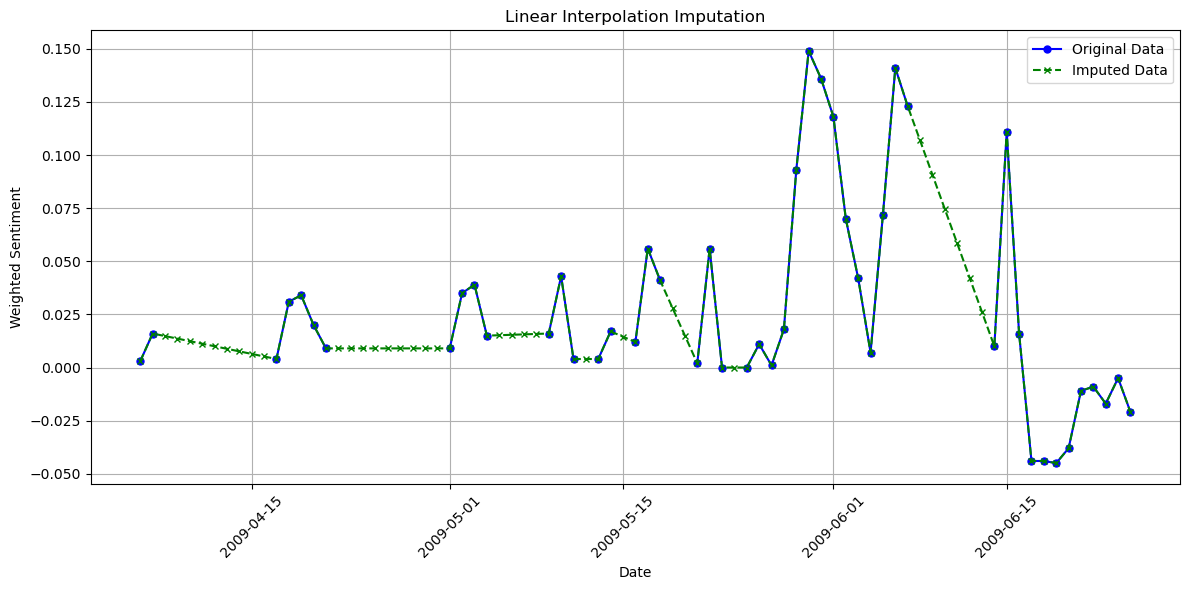

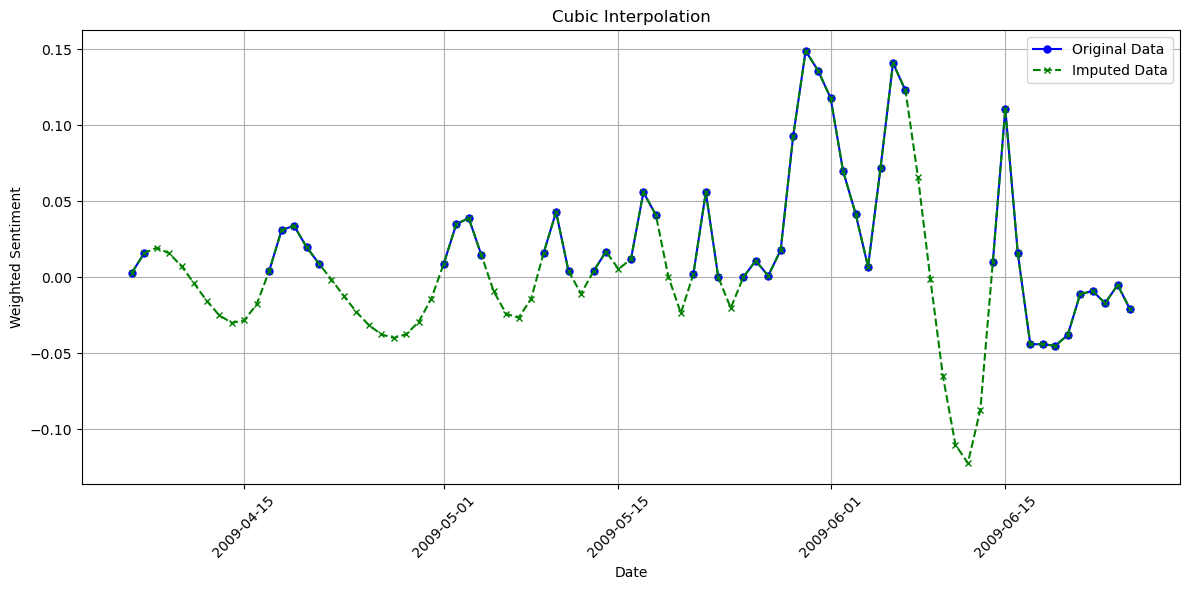

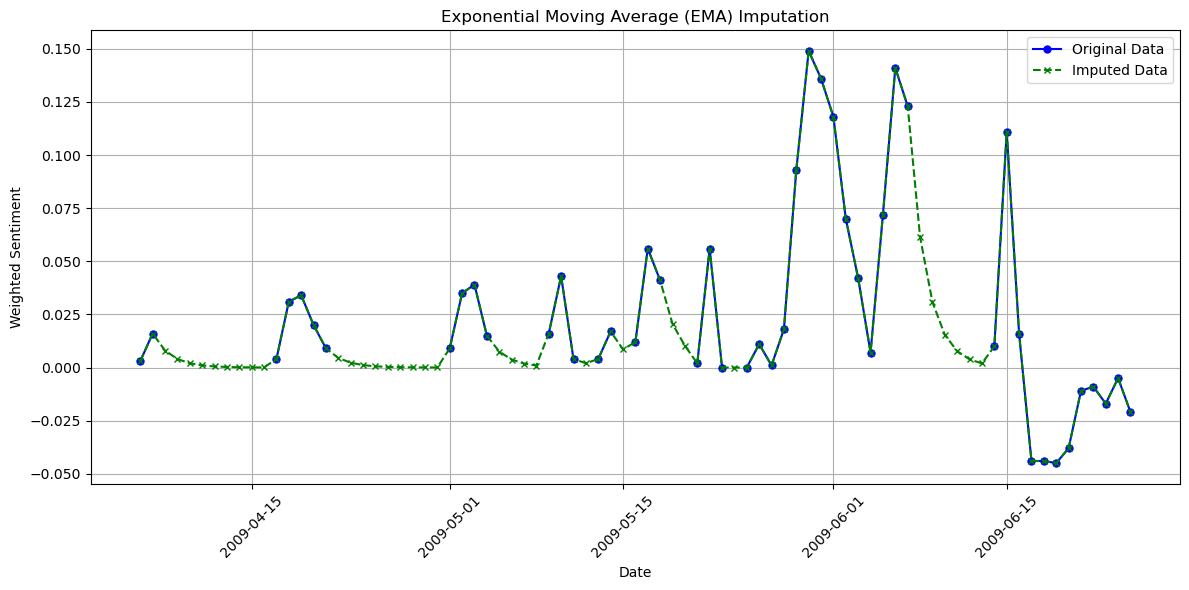

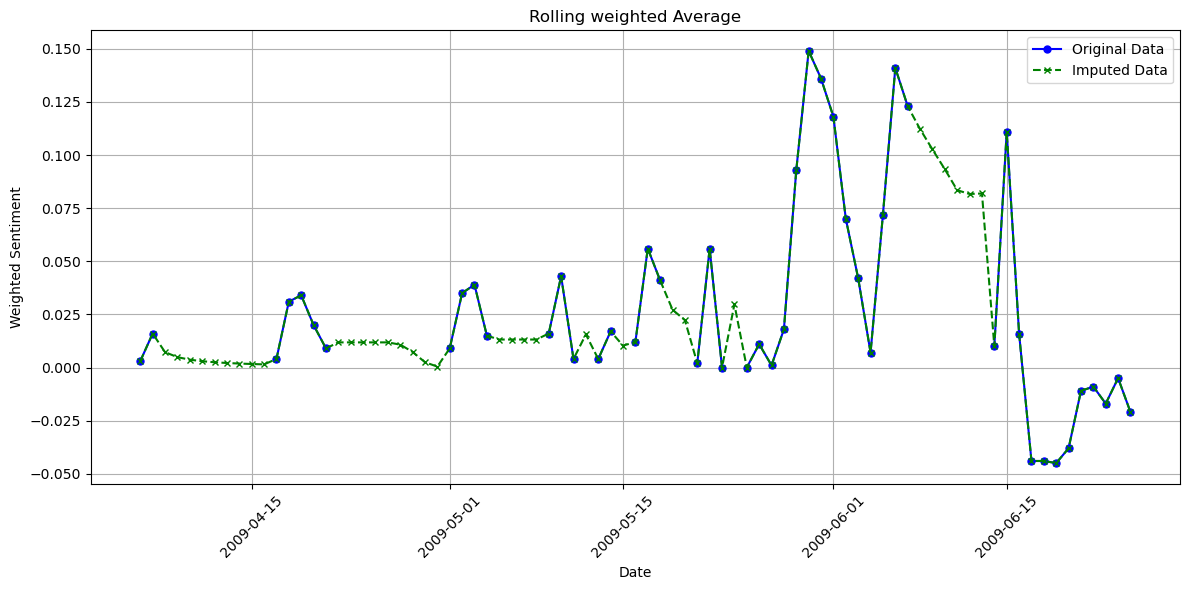

In [61]:
# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df['daily_records'], pandas_df['weighted_sentiment_linear_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Linear Interpolation Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df1['daily_records'], pandas_df1['weighted_sentiment_cubic_interp'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Cubic Interpolation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df2['daily_records'], pandas_df2['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Exponential Moving Average (EMA) Imputation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the original and imputed data with different markers and colors
plt.figure(figsize=(12, 6))
plt.plot(df_og['daily_records'], df_og['weighted_sentiment'], label='Original Data', marker='o', markersize=5, color='blue')
plt.plot(pandas_df3['daily_records'], pandas_df3['imputed_weighted_sentiment'], label='Imputed Data', linestyle='--', marker='x', markersize=5, color='green')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Rolling weighted Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Lineplots Analysis

- Linear: It presented the expected results adding scores in a linear way from on sentiment score to the other. The approach did not added any huge spikes or variation to the data.

- Cubic: The method added more variability to the dataframe, especially with a huge spike (negative) at the last quarter (the original lowets value was around -0.05 and after the approach was -0.1).

- EMA: The results are similar provided by the linear method, despite trying different alpha values (range between 0.1 and 1) the values and the shape barely suffered any change.

- Rolling Weighted Average: The approach presented scores that it does not add much variability to the scores and do not introduce huge spikes. However, it added more "seasonality" to the data with more ups and downs in comparison to the last techniques.  

In [62]:
# Applies .describe() to each DataFrame.
description_df = df_og['weighted_sentiment'].describe()
description_df1 = pandas_df['weighted_sentiment_linear_interp'].describe()
description_df2 = pandas_df1['weighted_sentiment_cubic_interp'].describe()
description_df3 = pandas_df2['imputed_weighted_sentiment'].describe()
description_df4 = pandas_df3['imputed_weighted_sentiment'].describe()

# Prints the statistics for further analysis.
print("Description of sentiment score without imputation:\n", description_df)
print("Description of sentiment score with linear imputation:\n", description_df1)
print("\nDescription of sentiment score with cubic imputation:\n", description_df2)
print("\nDescription of sentiment score with EMA imputation:\n", description_df3)
print("\nDescription of sentiment score with rolling weighted avg imputation:\n", description_df4)


Description of sentiment score without imputation:
 count    48.000000
mean      0.028125
std       0.048397
min      -0.045000
25%       0.001750
50%       0.015500
75%       0.042250
max       0.149000
Name: weighted_sentiment, dtype: float64
Description of sentiment score with linear imputation:
 count    81.000000
mean      0.025228
std       0.040544
min      -0.045000
25%       0.006400
50%       0.012400
75%       0.035000
max       0.149000
Name: weighted_sentiment_linear_interp, dtype: float64

Description of sentiment score with cubic imputation:
 count    81.000000
mean      0.007453
std       0.050017
min      -0.122247
25%      -0.021000
50%       0.002000
75%       0.019489
max       0.149000
Name: weighted_sentiment_cubic_interp, dtype: float64

Description of sentiment score with EMA imputation:
 count    81.000000
mean      0.019152
std       0.039398
min      -0.045000
25%       0.000281
50%       0.004500
75%       0.020500
max       0.149000
Name: imputed_weighted_s

#### Descriptive Statistics.

The statistical properties before and after de imputation shows that the Cubic approach caused the bigger change in its properties, increasing the standard deviation but also imputing negative values that reduced the minimum value of the sentiment score. In contrast, the rolling weighted AVG was the one that kept the properties closest to the original. 

Text(0.5, 1.0, 'Distribution Without Imputation')

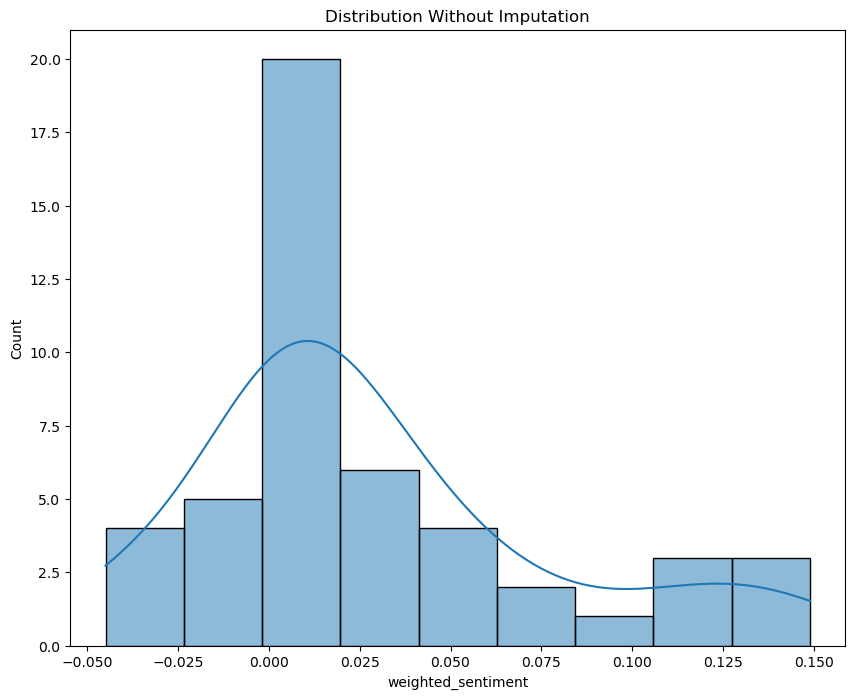

In [63]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot Distribution without imputations for comparison.
sns.histplot(df_og['weighted_sentiment'], kde=True)
plt.title('Distribution Without Imputation')

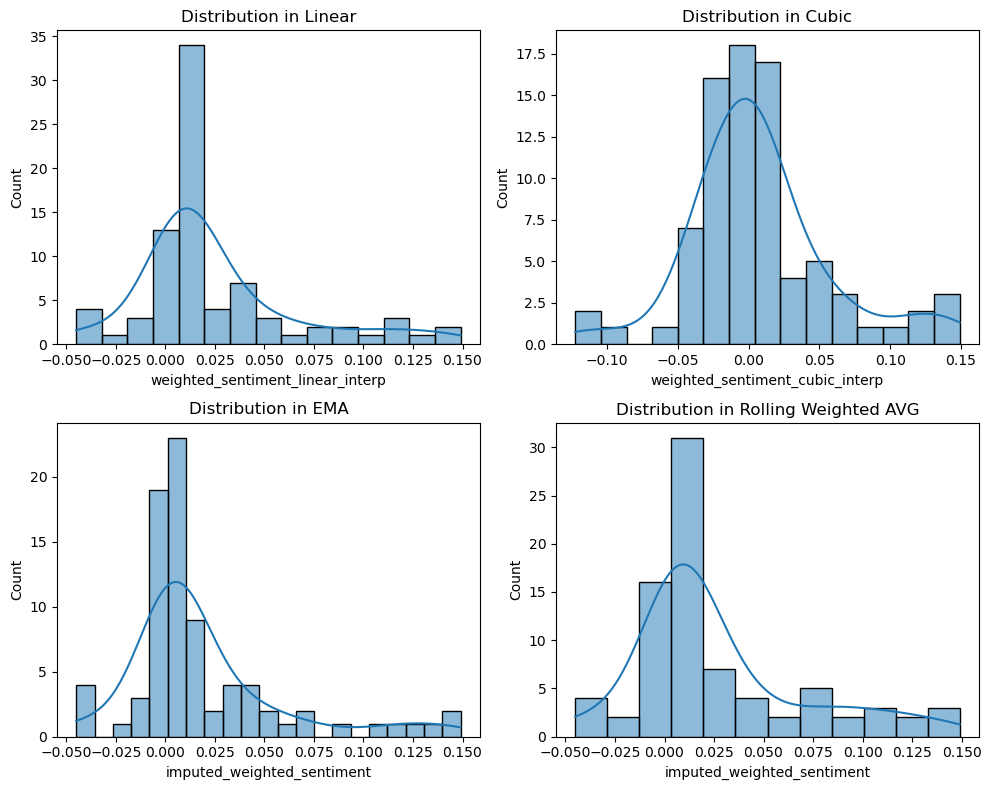

In [64]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Histogram with Linear Imputation
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear')

# Histogram with Cubic Imputation
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic')

# Histogram with EMA Imputation
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA')

# Histogram with Rolling Weighted Average Imputation
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots


#### Distribution Before and After Imputation

The distribution plots shows that techniches like the linear, EMA and rolling average maintain the shape close to the original which is slightly right-skewed. However, because the cubic imputation added not only more negative values but with a large scale it made the scores more normally distributed in comparison with the original. 

Text(0.5, 1.0, 'Boxplot Without Imputation')

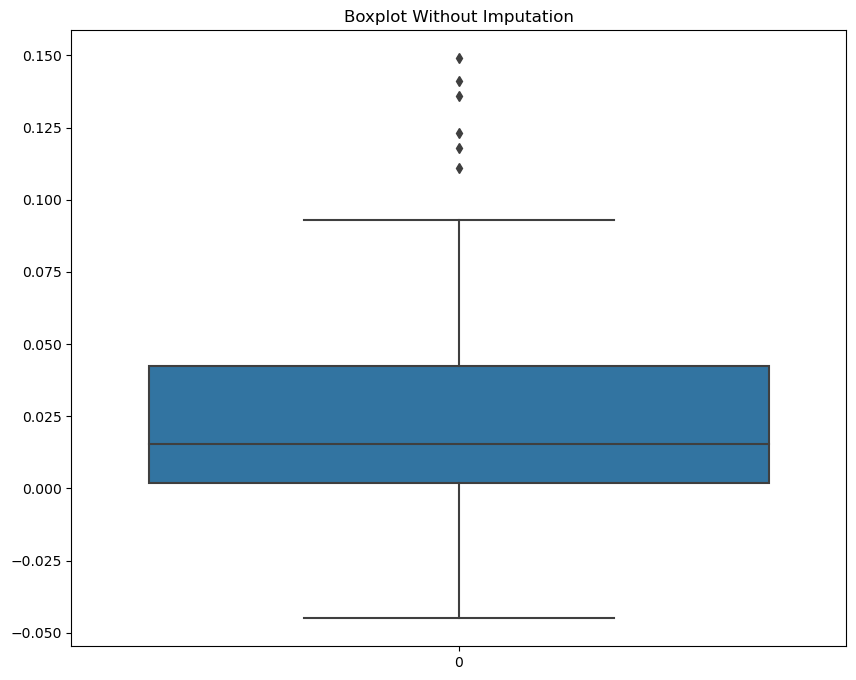

In [65]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Plot Boxplot without imputations for comparison.
sns.boxplot(df_og['weighted_sentiment'])
plt.title('Boxplot Without Imputation')

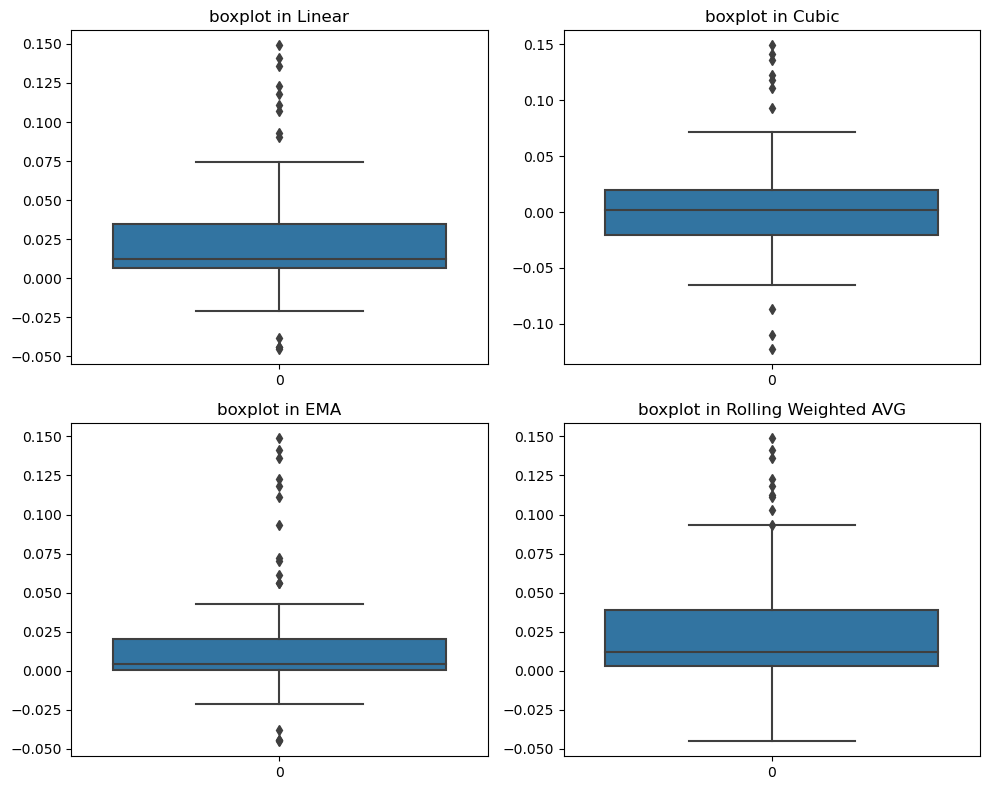

In [66]:
plt.figure(figsize=(10, 8))  # Set the size of the overall figure

# Boxplot with Linear Imputation
plt.subplot(2, 2, 1)  # Row 1, Column 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('boxplot in Linear')

# Boxplot with Cubic Imputation
plt.subplot(2, 2, 2)  # Row 1, Column 2
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('boxplot in Cubic')

# Boxplot with EMA Imputation
plt.subplot(2, 2, 3)  # Row 2, Column 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('boxplot in EMA')

# Boxplot with Rolling Weighted Average Imputation
plt.subplot(2, 2, 4)  # Row 2, Column 2
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('boxplot in Rolling Weighted AVG')

plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Display the plots

#### Boxplots

In terms of outliers the imputation techniques had a bad performance, especially for the linear, cubic and EMA where they presented a larger number of outliers on both sides of the skerwers. On the other hand, the rolling weighted avg, increase the number of outliers but, only at the side that the was already present in the original.

#### Considerations of the Analysis at this point

After analysing the imputations through fours stages, the rolling weighted average is the one that yielded better performance so far, due to:
- The lineplot showed that it did not introduced a lot of variation.
- The statistical properties stay very close to the original.
- The shape of the data remained close to the original. 
- The number of outliers increased, but in comparison with other approaches it did not generated outliers in the side that was not present in the original. 

Because time series analysis can be affected by outliers, the boxplot pointed numerous outliers in the scores (which is small already, 81). Therefore, the ultimate decision between the imputation techniques will be after applying different types of scalling (Robust Scalling, Power transformation).
- The chosen scaler techniques is because of the high variance of the data points, but also for the number of data points outside of the skewers (high number of outliers). They are more robust and less sensitive to outliers. 
- The evaluation of the techniques will be through histograms and boxplot.

#### Scalling the data

The results are displayed in the following way: 
- The results of the scalers will be displayed by imputation technique.
- The data that are going to be displayed will follow (No scaler, with RobustScaler and with PowerTransformation.
- The histogram will if the approach changed the shape of the data.
- The boxplot will focus on how the scaler handled the outliers. 

In [67]:
# Defining the Robust Scaler. 
scaler = RobustScaler()
# Applying the transformation directly on the imputed data.
pandas_df['robust_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['robust_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['robust_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['robust_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

In [68]:
# Defining the Power Transformer Scaler.
scaler = PowerTransformer(method='yeo-johnson')
# Applying the transformation directly on the imputed data.
pandas_df['power_sentiments'] = scaler.fit_transform(pandas_df['weighted_sentiment_linear_interp'].values.reshape(-1, 1))
pandas_df1['power_sentiments'] = scaler.fit_transform(pandas_df1['weighted_sentiment_cubic_interp'].values.reshape(-1, 1))
pandas_df2['power_sentiments'] = scaler.fit_transform(pandas_df2['imputed_weighted_sentiment'].values.reshape(-1, 1))
pandas_df3['power_sentiments'] = scaler.fit_transform(pandas_df3['imputed_weighted_sentiment'].values.reshape(-1, 1))

### Scaler on linear imputation scores. 

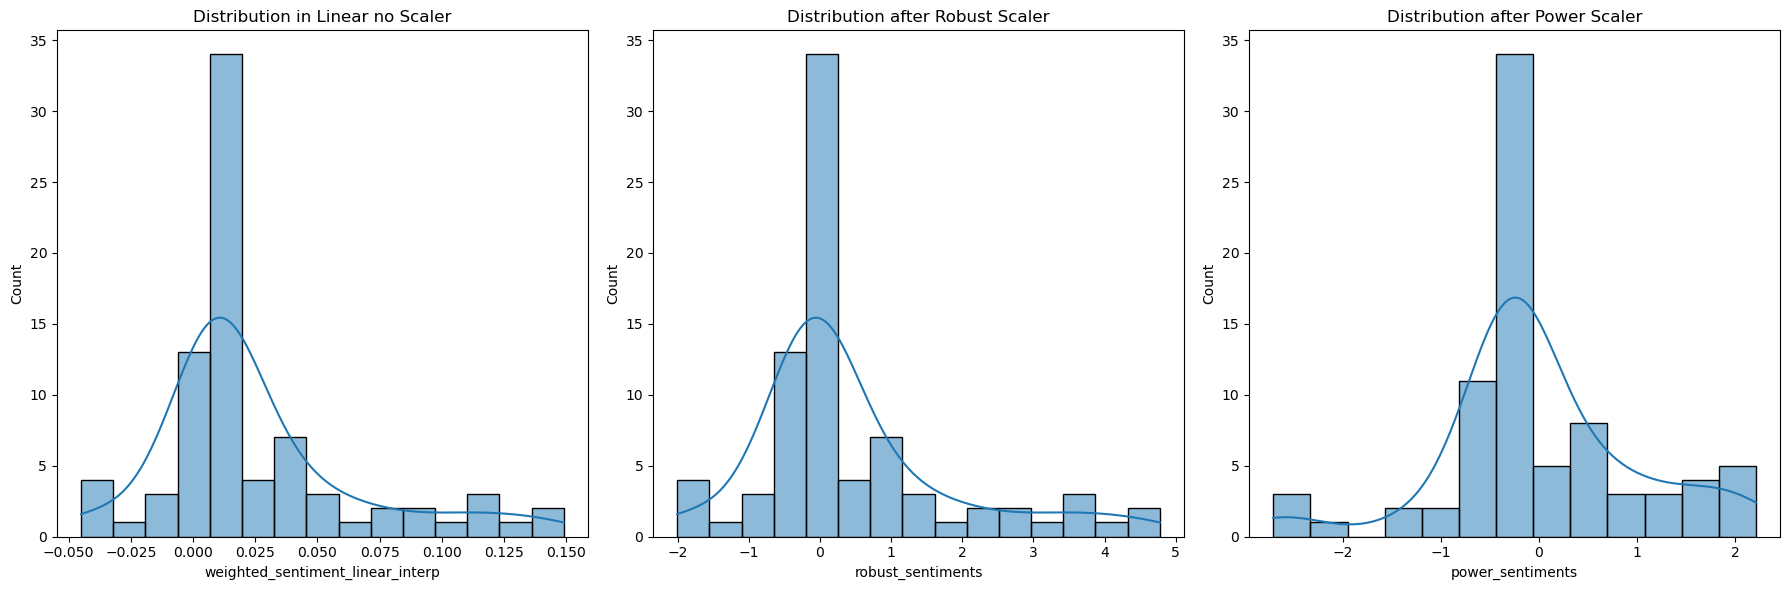

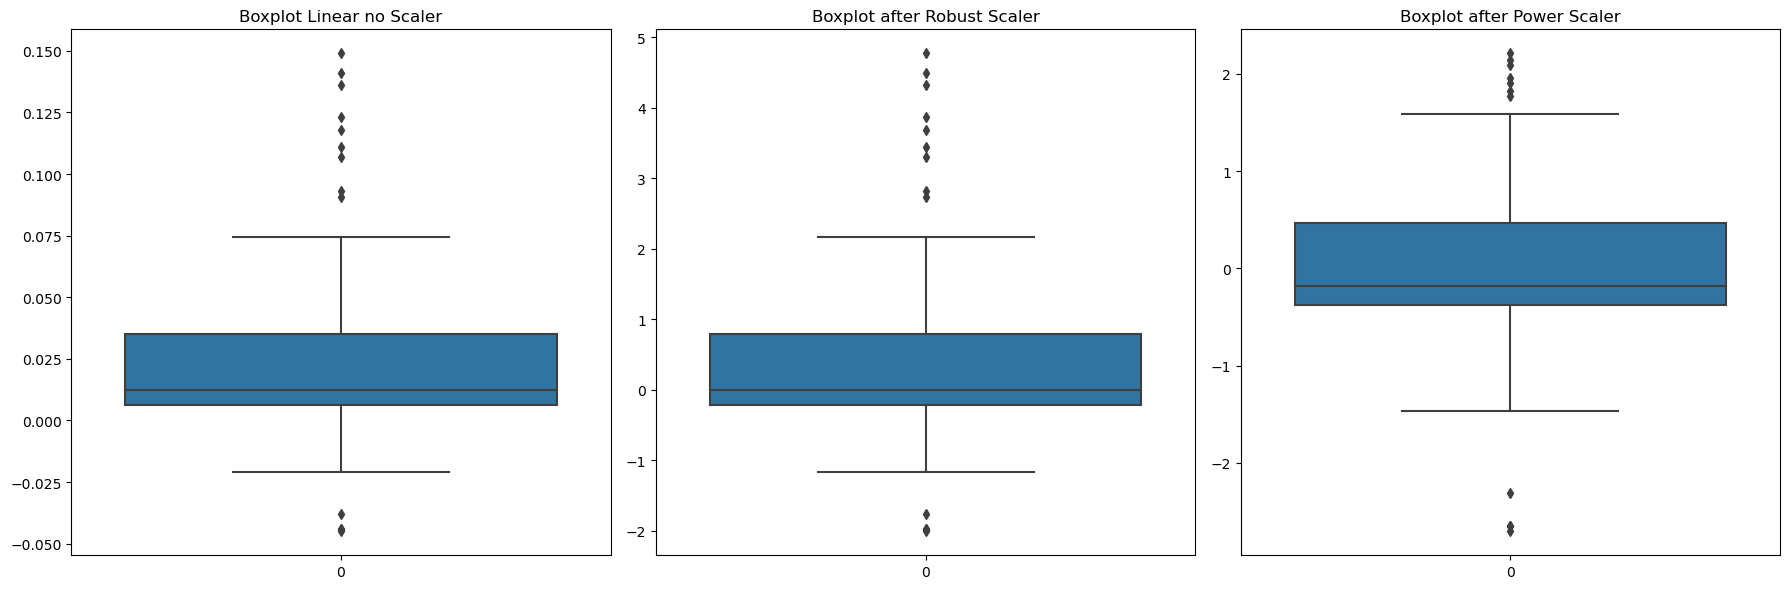

In [69]:
# Set the overall size of the plot.
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler.
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df['weighted_sentiment_linear_interp'], kde=True)
plt.title('Distribution in Linear no Scaler')

# Plot for Robust Scaler.
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler.
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plots.
plt.tight_layout()  # Adjust the layouts.
plt.show()

# Set the overall size of the plots
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler.
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df['weighted_sentiment_linear_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler.
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler.
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plots.
plt.tight_layout()  # Adjust the layouts.
plt.show()

- In the linear imputation, the scaler that had most impact was the power transformation. The histogram shows that the data became more normally distributed. Although, the technique was not successful in handling the outliers.

### Scaler on cubic imputation scores. 

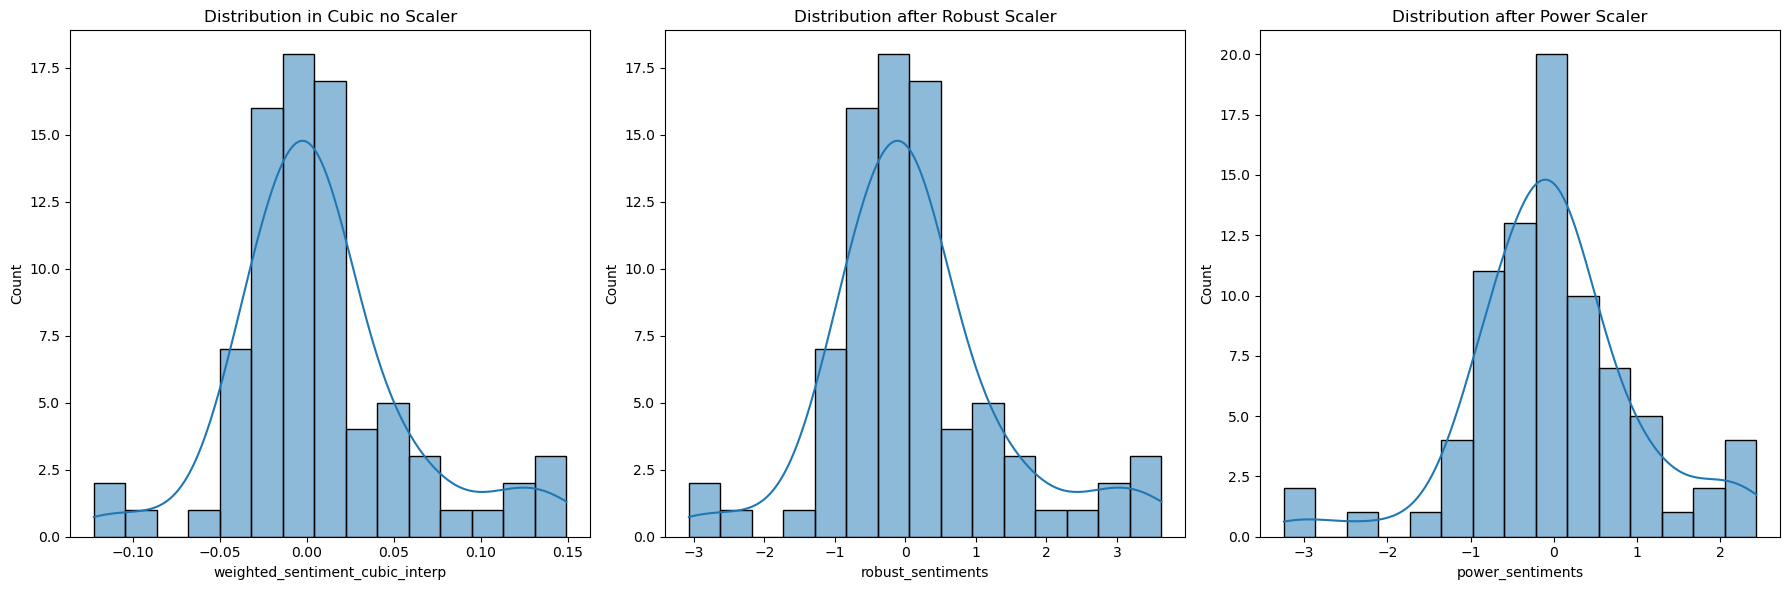

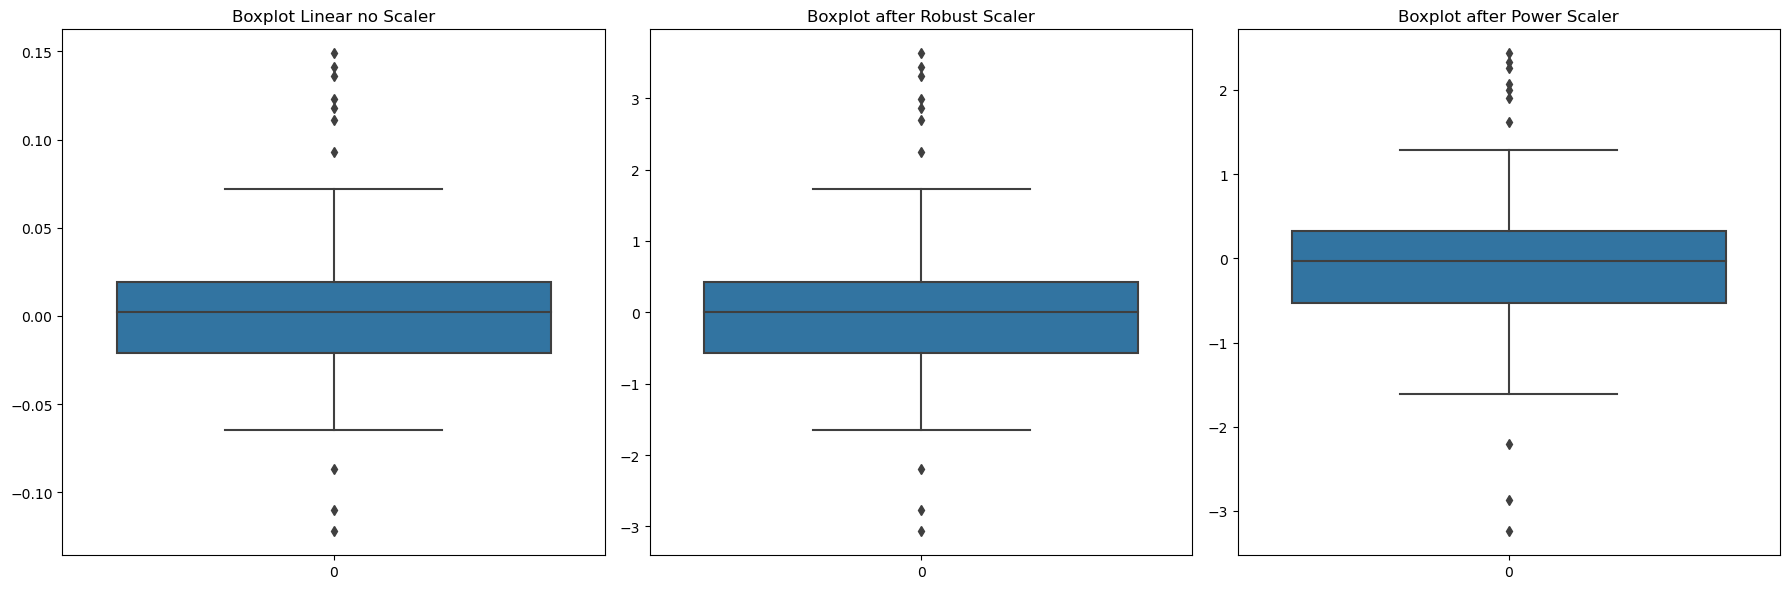

In [70]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df1['weighted_sentiment_cubic_interp'], kde=True)
plt.title('Distribution in Cubic no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df1['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df1['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df1['weighted_sentiment_cubic_interp'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df1['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df1['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The approaches yielded the same results as the linear imputation regarding the outliers, both of the scalers were not able to handle the outliers using the cubic imputations. 

### Scaler on EMA imputation scores. 

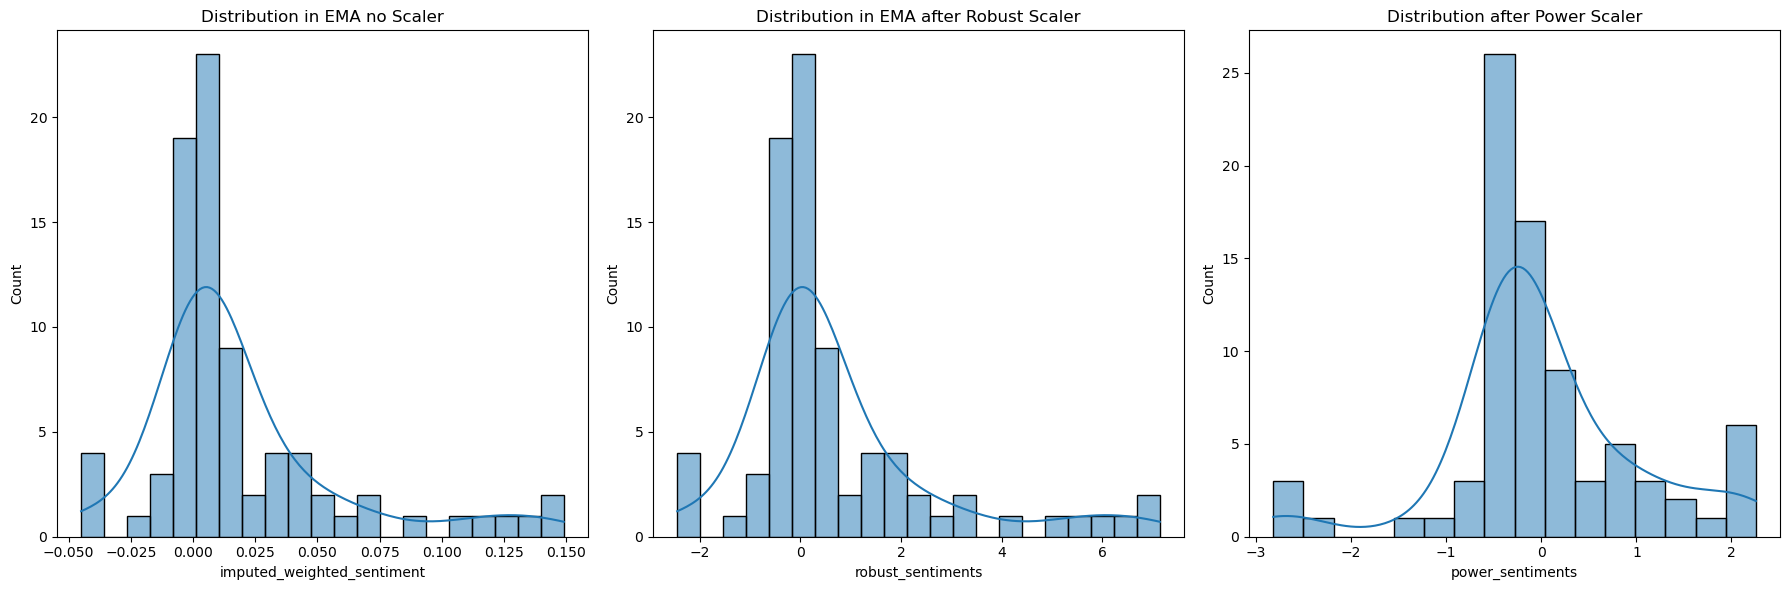

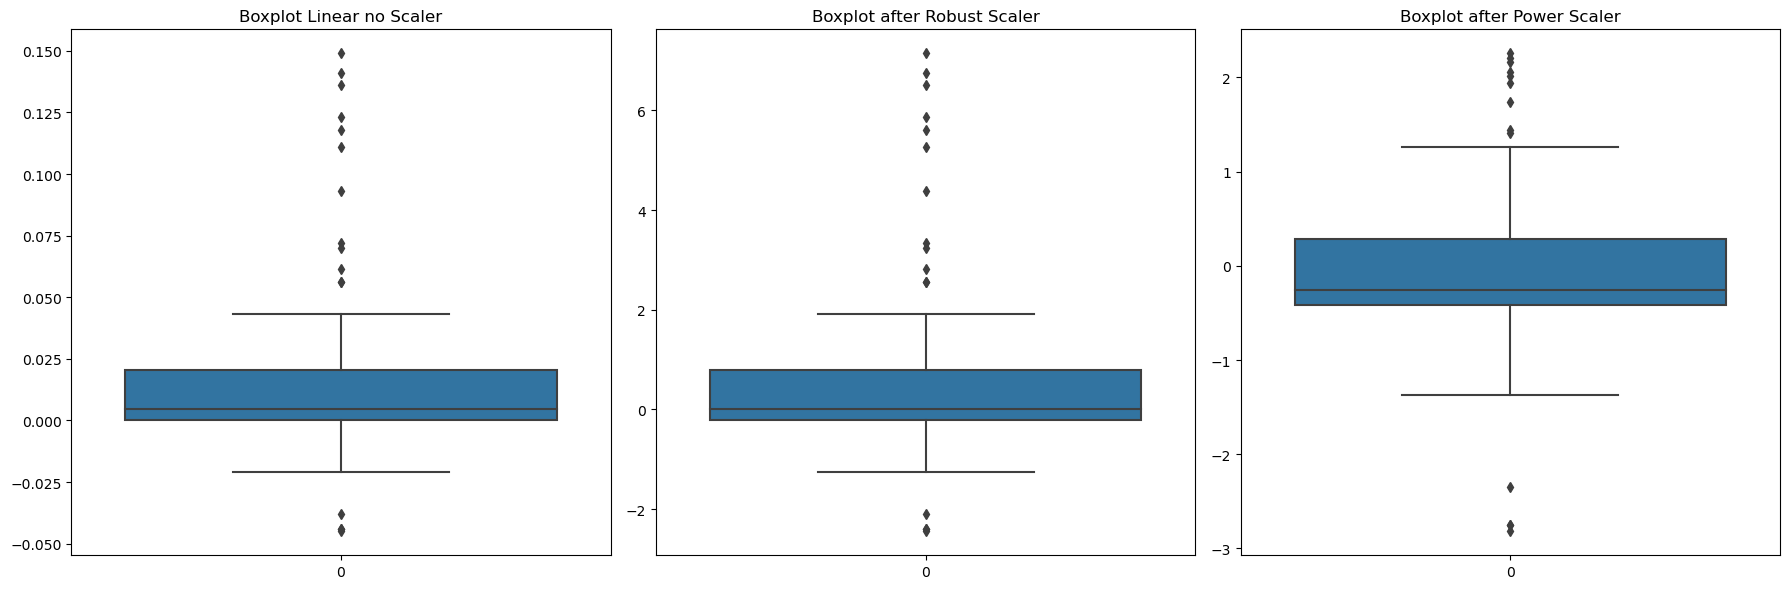

In [71]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df2['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution in EMA no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df2['robust_sentiments'], kde=True)
plt.title('Distribution in EMA after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df2['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df2['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df2['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df2['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The scalers made the distribution more normally distributed. However, it did not had the effect expected to handle outliers.

### Scaler on rolling weighted avg imputation scores. 

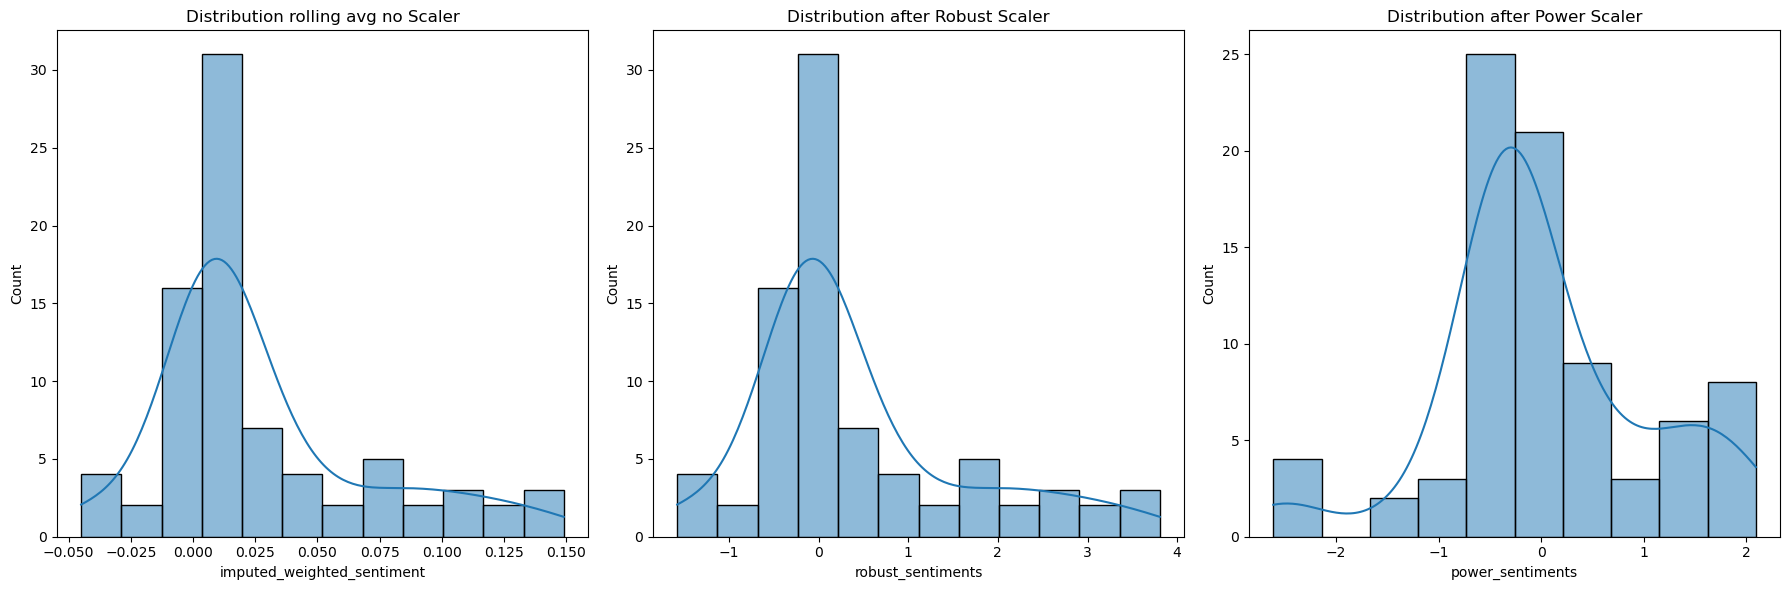

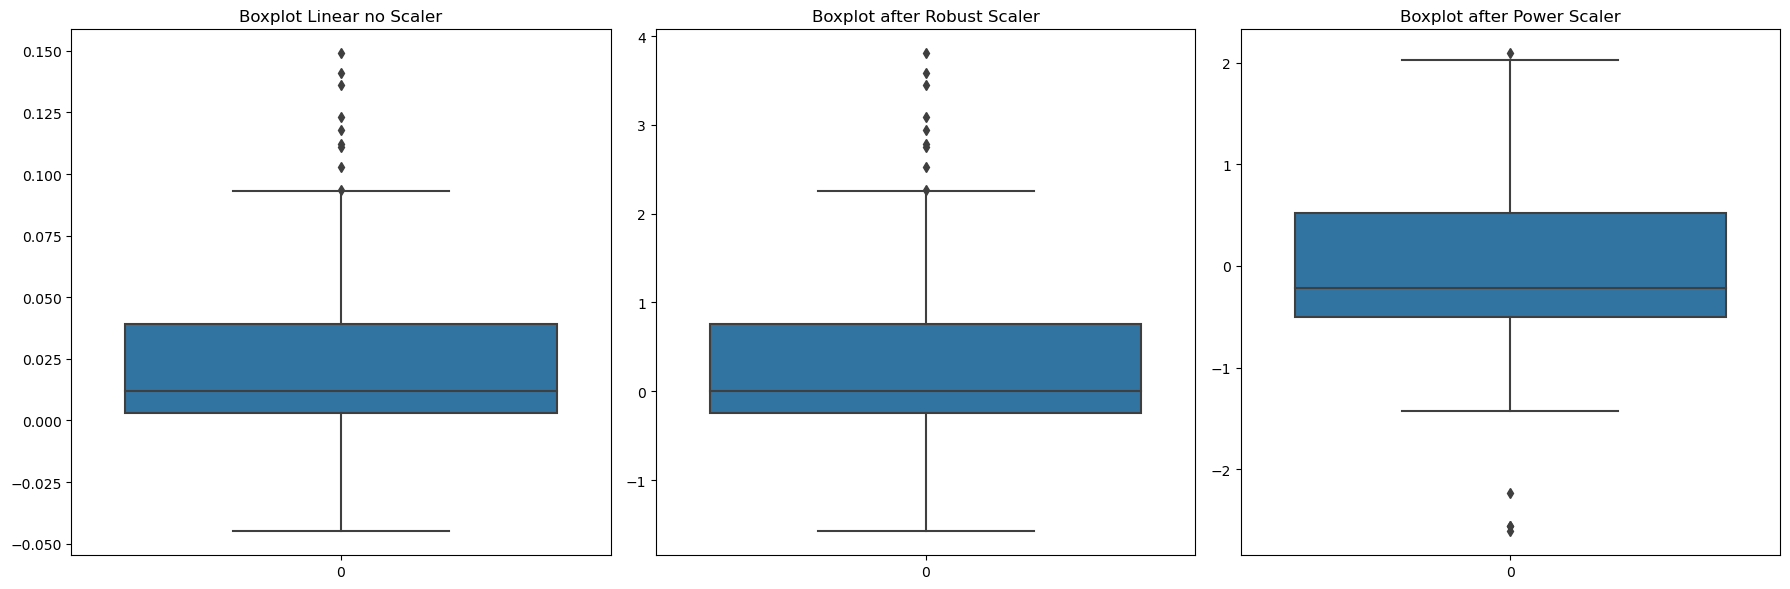

In [72]:
# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.histplot(pandas_df3['imputed_weighted_sentiment'], kde=True)
plt.title('Distribution rolling avg no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.histplot(pandas_df3['robust_sentiments'], kde=True)
plt.title('Distribution after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.histplot(pandas_df3['power_sentiments'], kde=True)
plt.title('Distribution after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

# Set the overall size of the plot
plt.figure(figsize=(18, 6)) 

# Plot for without Scaler
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(pandas_df3['imputed_weighted_sentiment'])
plt.title('Boxplot Linear no Scaler')

# Plot for Robust Scaler
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
sns.boxplot(pandas_df3['robust_sentiments'])
plt.title('Boxplot after Robust Scaler')

# Plot for Power Scaler
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
sns.boxplot(pandas_df3['power_sentiments'])
plt.title('Boxplot after Power Scaler')

# Display the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- The scalers had more impact when applied at the scores with rolling weighted avg, shifting the most frequent values to the center, making it more normally distributed. 
- Regarding the outliers, it reduced the number of outliers, but by shifting the box to the center it created outliers at the other side of the skewer, which was not present at the "original". 

#### Selecting the techniques

The selection of the approaches combined is the Rolling Weighted Average and scalling with the PowerTransformer. The reasons is because the imputation technique resulted in few variations, but the statistical properties remained close to the original.
Meanwhile, the scalling approach was chosen due to the normalization of the data, but mainly considering the reduction of outliers. 

#### The data to be used in time series analysis in the power_sentiments, which is the overall sentiment scores

Transformations occured to the scores since the polarity extraction:
- Weighted Average (Daily Aggregation);
- Imputation using Rolling Weighted Average; 
- Power Transformer Scaler; 

## Time-Series Analysis

Before deciding what type of models to apply, characteristcs of the series, such as trends and seasonality will be analysed to help in decide the most appropriate model for the time series.

In [73]:
# Creating a copy of the selected dataframe to apply time series analysis.
final_df = pandas_df3
final_df.head() # Display the first five rows.

,daily_records,weight,weighted_sentiment,imputed_weighted_sentiment,robust_sentiments,power_sentiments
0,2009-04-06,0.030010,0.003,0.003000,-0.244884,-0.499867
1,2009-04-07,0.155140,0.016,0.016000,0.115806,-0.087437
2,2009-04-08,0.171115,NaN,0.007220,-0.127795,-0.359797
3,2009-04-09,0.171115,NaN,0.004877,-0.192793,-0.436787
4,2009-04-10,0.171115,NaN,0.003683,-0.225945,-0.476789


In [74]:
# Drop the columns that no longer needed for next steps.
final_df = final_df.drop(['weight', 'weighted_sentiment', 'imputed_weighted_sentiment', 'robust_sentiments'], axis=1)

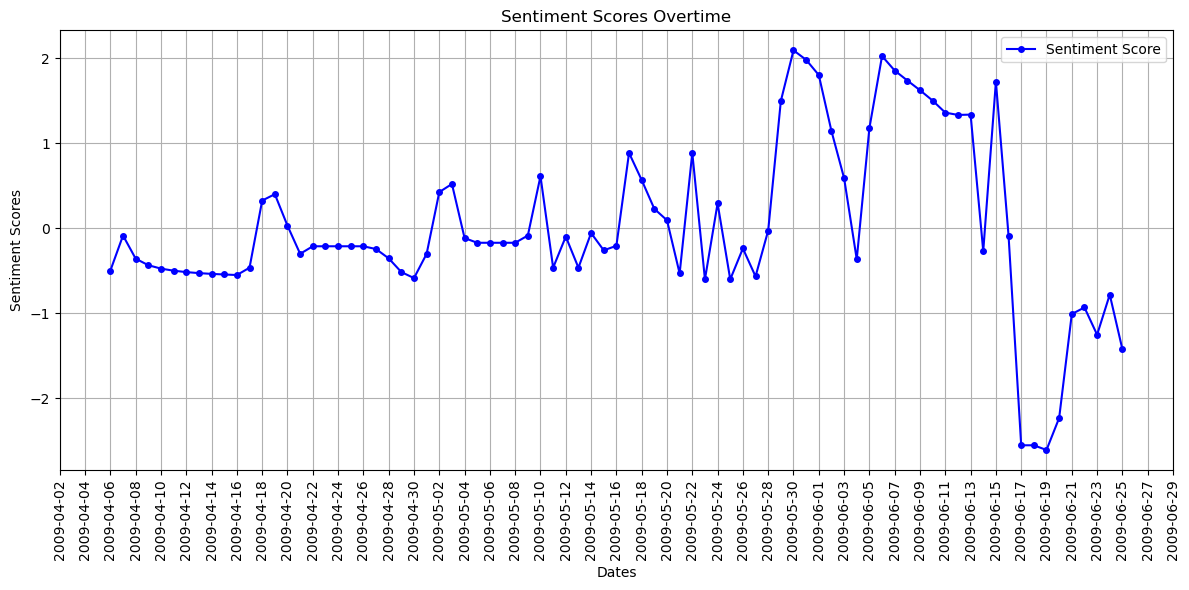

In [75]:
# Plot the sentiment scores overtime with imputations. 
plt.figure(figsize=(12, 6))
plt.plot(final_df['daily_records'], final_df['power_sentiments'], label='Sentiment Score', marker='o', markersize=4, color='blue')
plt.xlabel('Dates')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Scores Overtime')
plt.legend()
plt.grid(True)

# Set x-axis to show all the recorded dates. 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Shows a date every 2 days.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Type of the date to be shown.
 # Increases readability.
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- With all the gaps filled the next step is to investigate seasonality and trends in the sentiment scores overtime. But, through the line plot it is not observable trends or seasonality, thus performing the seasonal decompose to futher analyse its composition.

In [76]:
# Ensures the series is indexed by time and daily frequency
final_df.index = pd.date_range(start='2009-04-06', periods=len(final_df), freq='D')

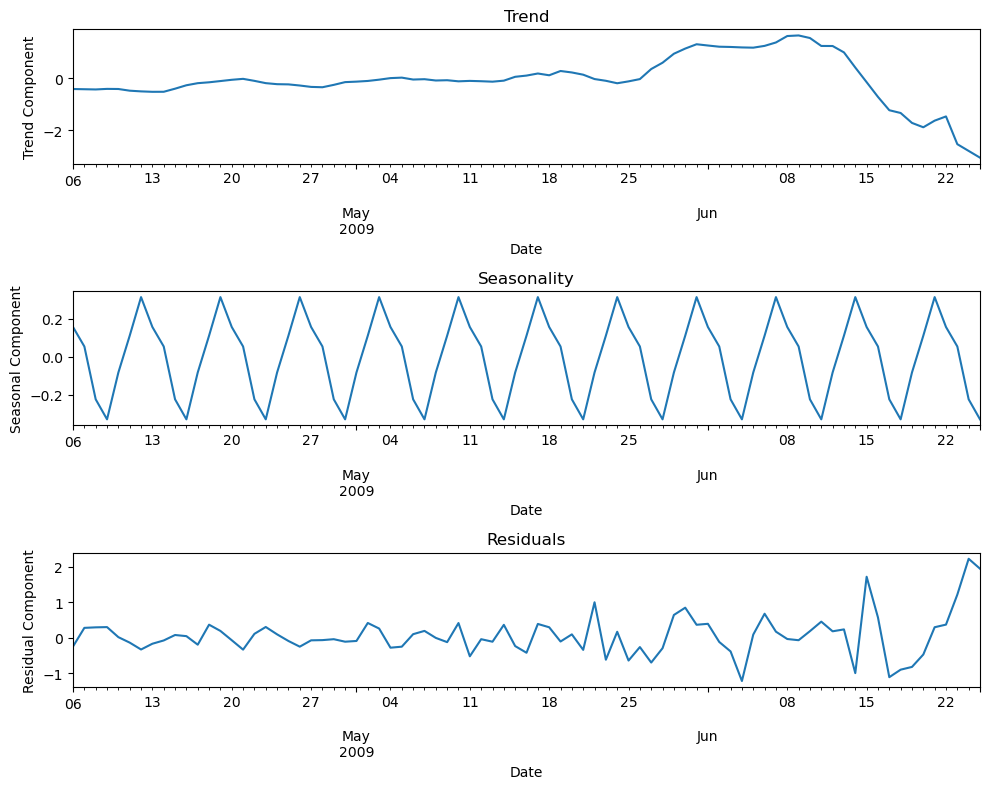

In [77]:
# Decomposing the time series.
decomposition = seasonal_decompose(final_df['power_sentiments'], 
                                   model='additive', 
                                   period=7,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

The seasonal decompose shows that:
Trend: The sentiments scores has a down trend, which is to decrease over time. After mid June the score slumped.  

Seasonality: In a period of 7 days (a week), the sentiments have a clear seasonality. 
1. The first data point in the record is April the 6th, a Monday and considering the "full cycle" of the seasonality, there are a few considerations:
- Thursdays are the days that the sentiments hits the lower score.
- Fridays the scores starts to increase which lasts until Sunday (the peak).
Therefore, knowing that are clear seasonality in period of a week
This could be a mood of an "average" person, not great during business days, but happier on the weekends.

Residuals: The plot shows how distorted is from the value of 0, thus there are changes that can be made that will improve methods. 

The seasonal decompose is mainly for auto regressive models, which also requires the series to be stationary. And based on the three plots, the sentiment scores will need to be differenced by the clear weekly seasonality the transformation will use 7 lags.

<Figure size 1400x700 with 0 Axes>

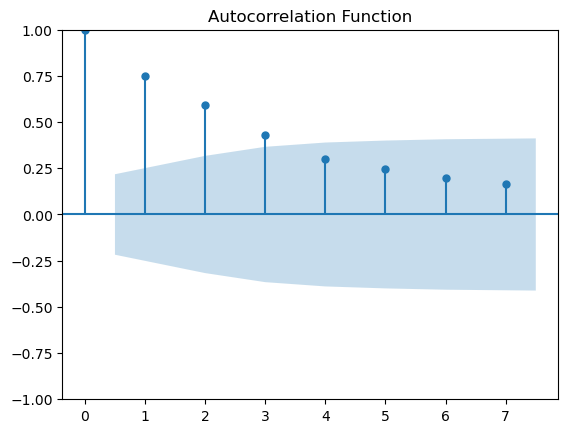

<Figure size 1400x700 with 0 Axes>

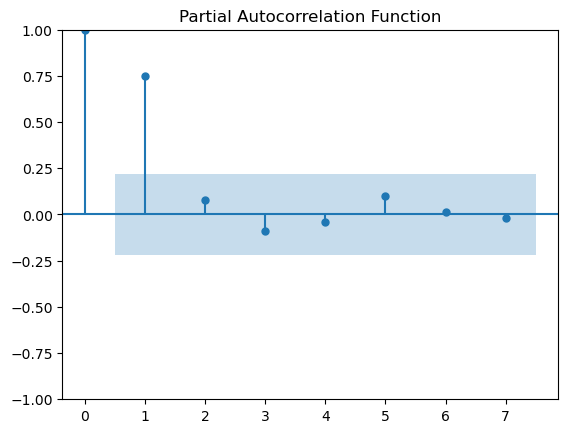

In [81]:
# Because the frequency is in days, the lags used for the plots is 7.
n_lags = 7

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(final_df['power_sentiments'], lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(final_df['power_sentiments'], lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()

In [82]:
# Augmented Dickey-Fuller test
adf_test = adfuller(final_df['power_sentiments'],  maxlag=7, autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': -1.871336456202474,
 'p-value': 0.34566312531475374,
 'Lags Used': 7,
 'Number of Observations Used': 73,
 'Critical Values': {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123}}

After analysing the previous codes using lags of 7, the chosen time series models are the auto regressives. 
ARIMA and SARIMA will be performed and evaluated in this project. These types of models:
- The level of implementation complexity.
- Daily sentiments shows some correlations, where can be visualized at the ACF plot and also trends with no pattern, however it has a big slump at the end. Based on these features, ARIMA model is an appropriate choice.
- At the seasonal decompose, a strong seasonality was indetified and models like SARIMA is a good choice. 
- Both of the models can adapt to different scenarios by adjusting the parameters and the use of hyperparamenter tunning can speed up the process to find the best order for the models. 

The models have the assumption that the series is stationary, thus the following steps will check and address it if its necessary.
To support the theory of stationary ADF test was performed

#### Differencing sentiment scores.

Based of the test results, where the pvalue is way above 0.05 (not stationary), but also with the presence of seasonality, the sentiment scores will need to be transformed. And by following the models assumption, differencing will be performed, in the attempt to make it stationary. 
- The approach will use the lag of 7, as observed previously to also tackle the observed seasonality. 

In [83]:
# Differencing the sentiment scores
df7 = final_df['power_sentiments'].diff(7)  # Difference with 7 lags

# To remove NaN values, the approach will generate the first observation to be NaN value.
df7 = df7.dropna()

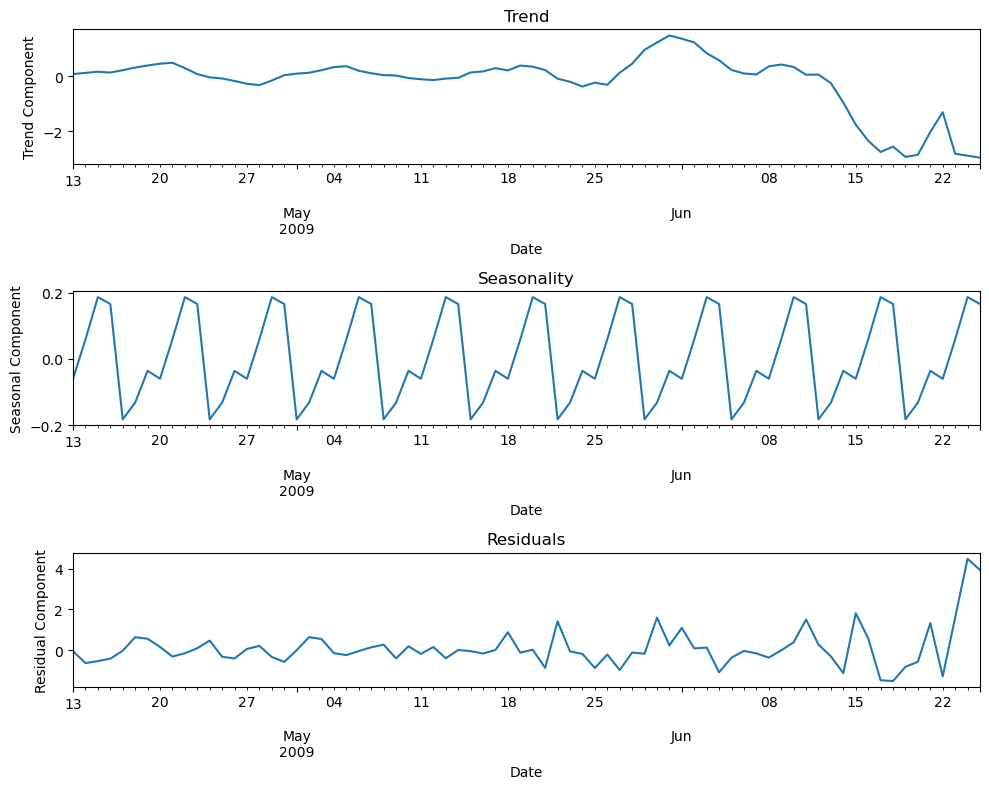

In [84]:
# Decomposing the time series.
decomposition = seasonal_decompose(df7, 
                                   model='additive', 
                                   period=7,  # Weekly seasonality
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

In [85]:
# Augmented Dickey-Fuller test
adf_test = adfuller(df7,  maxlag=7, autolag=None)

adf_result = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result

{'Test Statistic': -1.7950446337082493,
 'p-value': 0.38292465599920106,
 'Lags Used': 7,
 'Number of Observations Used': 66,
 'Critical Values': {'1%': -3.5335601309235605,
  '5%': -2.9064436883991434,
  '10%': -2.590723948576676}}

<Figure size 1400x700 with 0 Axes>

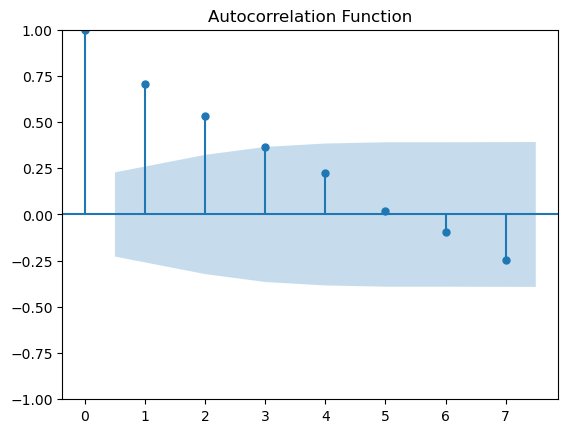

<Figure size 1400x700 with 0 Axes>

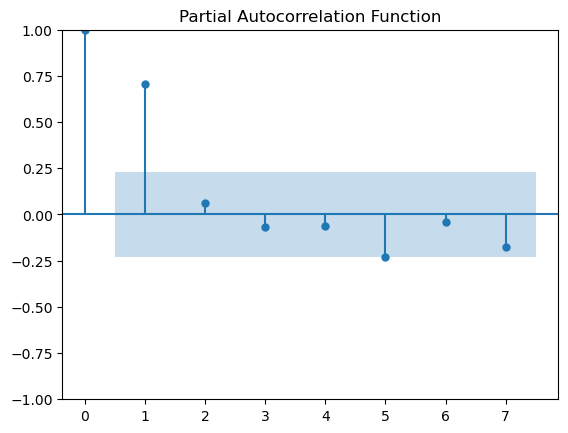

In [87]:
# Because the frequency is in days, the lags used for the plots is 7.
n_lags = 7

# Plot the ACF
plt.figure(figsize=(14, 7))
plot_acf(df7, lags=n_lags, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plt.figure(figsize=(14, 7))
plot_pacf(df7, lags=n_lags, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function')
plt.show()

In [90]:
# Differencing the sentiment scores
dftest = df7.diff(7)  # Difference with 7 lags

# To remove NaN values, the approach will generate the first observation to be NaN value.
dftest = dftest.dropna()

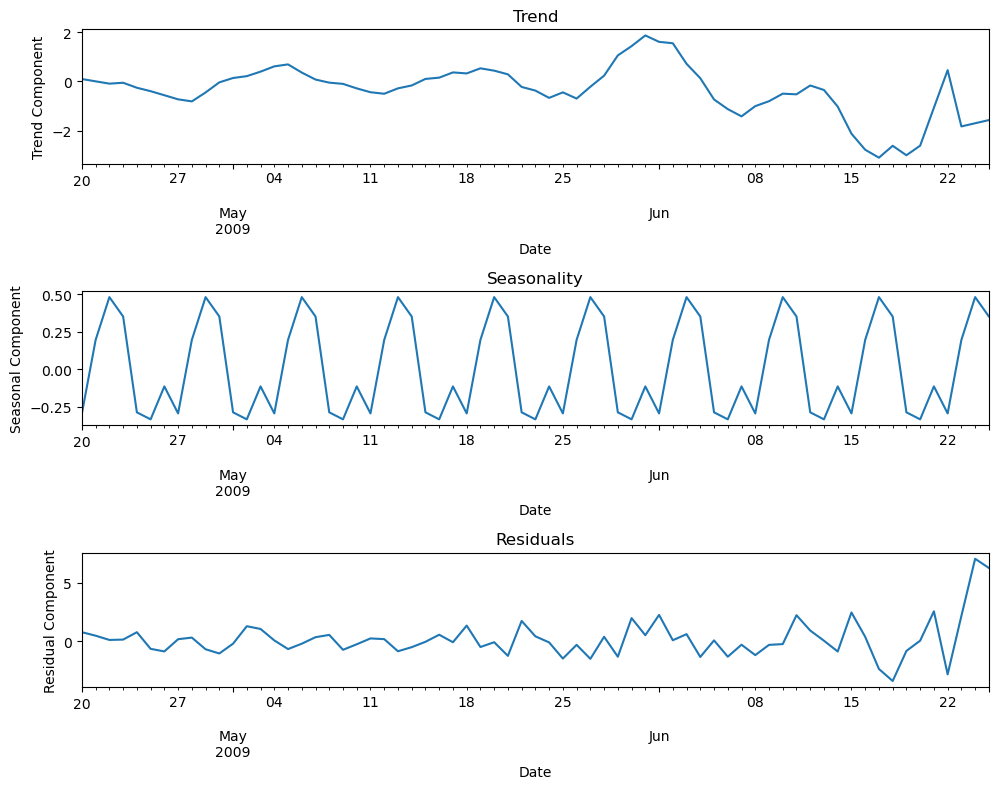

In [91]:
# Decomposing the time series.
decomposition = seasonal_decompose(dftest, 
                                   model='additive', 
                                   period=7,  # Weekly seasonality
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

- After differencing with 7 lags, the seasonal decompose shows that the series still presents some seasonality, going up and down for 2 days, but also going up and down for the next 4 days.
- Next models will be attemped after the first lag to check if the approaches can generate well and capture the complexity of the scores.

#### Spliting the data into train and test. 

- The train set will be composed of 90% and the test 10%, which is the "limit" of standard practise as discuss in class, the decision of 10% is also based on the fact the the dataset has a small number of observations.

### Metrics to evaluate the model while testing parameters. 

- Two metrics will be taken into account during this stage, the AIC (to check how good the model is fitting into the data and its complexity) and MSE (the performance of predicions). 
- The objective is to balance goodness and performance of the models, which will also be used to compared different approaches.
- The metric with bigger weight will be the MSE, since one of the objectives of this project is to forecast. 
- Lineplots will also help with the evaluation part of the model. 

In [92]:
# Split the data into train and test sets
train_size = int(len(df7) * 0.9)
train, test = df7[0:train_size], df7[train_size:]

### Auto Regressive 

- Based on the features of the time series, this approach is more for experimentation purpose. 

In [ ]:
# Fit an AR(7) model
model = AutoReg(train['power_sentiments'], lags=7)
model_fit = model.fit()
    
# Summary of the model
print(model_fit.summary())

# Make predictions
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Calculate metrics
mse = mean_squared_error(test['power_sentiments'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['power_sentiments'], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test['power_sentiments'], label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('AR Model Predictions vs Actual')
plt.show()

- All numbers provided by the algorithm were attempted but the lag=7 yielded better results comparing to others between the range of 0 to 9.
- Also, the lineplot had a significant weight to decide the number of lags.  

### Auto Regressive Moving Average (ARMA)

In [ ]:
# Defines the range of values for p and q to try.
p_range = range(9)
q_range = range(9)
mse_values = []

# Grid search over p_range and q_range.
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARMA model with the current p and q values.
            model = ARIMA(train, order=(p, 0, q))
            model_fit = model.fit()
            
            # Make predictions on the test set.
            start = len(train)
            end = start + len(test) - 1
            predictions = model_fit.predict(start=start, end=end)
            
            # Calculate MSE and append to list
            mse = mean_squared_error(test, predictions)
            mse_values.append((mse, (p, q)))
        except:  # This is a catch-all exceptions.
            continue

# Sort the list of MSE values in ascending order (the lower the better).
mse_values.sort()

# Get the top 5 models with the lowest MSE values.
top_5_models = mse_values[:5]

# Prints the top 5 order based on MSE.
print("Top 5 ARMA models by MSE:")
for mse, order in top_5_models:
    print(f'ARMA{order} with MSE: {mse}')


- The order provided by the grid search using MSE, despite testing all of orders the one that yielded a better result was the (5, 0).
- The selection of the order were done by analysing the line plots, balancing the MSE and and AIC values. 

In [ ]:
# Order based on the grid search.
p = 5 
q = 0 
d = 0 # The time series is stationary, so d is 0

# Fit the ARMA model using the training data
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Print out the summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- By observivng the predicted values, the model enhanced its predictions in comparison to the Auto Regressive Approach. 

### ARIMA 

For the next model the parameters used is from the auto_arima, it does not require a lot of resources, it performs a stepwise approach, thus a starting point for the paramentes of the model. 

- The model is composed by the auto regressive, moving average and differecing in  the the model, thus expecting that the model will capture the data complexity and generate good predictions.

In [96]:
f# Fit the auto_arima model
model = pm.auto_arima(df7, start_p=0, start_d=0, start_q=0, max_p=5, max_d=1, max_q=5, seasonal=True, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Print the best model's AIC
print(f'Best ARIMA model by auto_arima: {model} with AIC: {model.aic()}')


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=247.025, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=197.143, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=218.328, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=245.494, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=198.662, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=198.783, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=195.772, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=197.584, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=199.895, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=199.728, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=193.798, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=196.804, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=196.681, Time

- With many possibilities, the initial model parameter will be based on the auto_arima (AIC metric).

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   66
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -76.370
Date:                Thu, 16 Nov 2023   AIC                            158.741
Time:                        16:22:31   BIC                            165.310
Sample:                    04-13-2009   HQIC                           161.337
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0416      0.302     -0.138      0.890      -0.633       0.550
ar.L1          0.6789      0.098      6.914      0.000       0.486       0.871
sigma2         0.5868      0.079      7.410      0.0

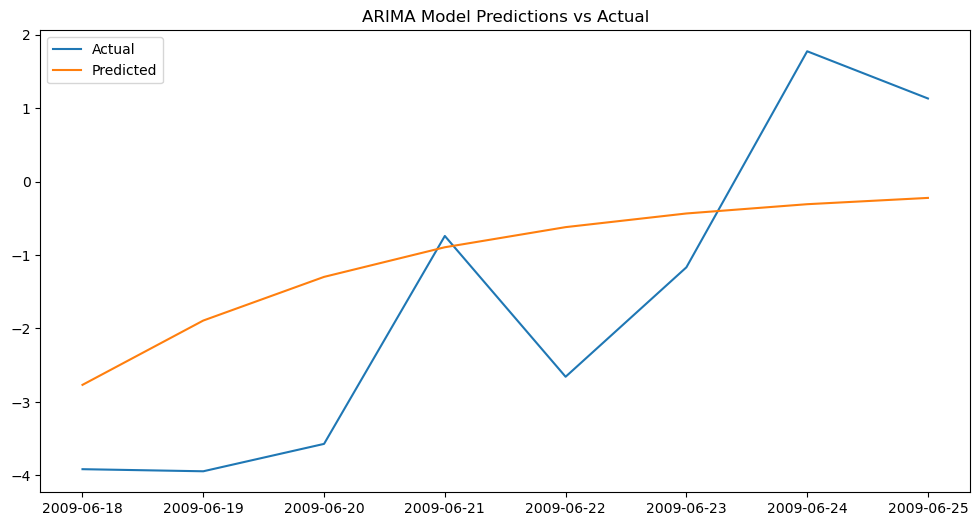

MSE: 2.6958107144833647
RMSE: 1.6418924186691906
MAE: 1.4788091391331133


In [98]:
# Fit an ARIMA(2,0,1) model based on auto_arima results.
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- Due to the Stepwise algorithm, the results of the auto_arima might not be the optimal values for the ARIMA parameters. Thus, a grid search will be applied to go through all the combinations in a given range to provide the best values for (p, d, q) throught the AIC and MSE.

In [99]:
warnings.filterwarnings("ignore")

# Define the range of values for p, d, and q to try
p = range(0, 9)
d = range(0, 2)
q = range(0, 9)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# List to store a tuple of (AIC, (p, d, q)) for each model
aic_values = []

# Grid search over pdq combinations
for combination in pdq:
    try:
        model = ARIMA(train, order=combination)
        results = model.fit()
        # Save the AIC and the (p, d, q) combination
        aic_values.append((results.aic, combination))
    except:
        continue

# Sort the list of AIC values in ascending order (lower AIC is better)
aic_values.sort(key=lambda x: x[0])

# Get the top 5 models with the lowest AIC values
top_5_models = aic_values[:5]

print("Top 5 ARIMA models by AIC:")
for aic, order in top_5_models:
    print(f'ARIMA{order} with AIC: {aic}')

Top 5 ARIMA models by AIC:
ARIMA(1, 1, 7) with AIC: 138.22353119045286
ARIMA(2, 0, 7) with AIC: 138.9101600240727
ARIMA(1, 1, 8) with AIC: 140.22198009908772
ARIMA(2, 1, 7) with AIC: 140.22229287047864
ARIMA(3, 0, 8) with AIC: 140.23298437922404


In [103]:
warnings.filterwarnings("ignore")

# Define the range of values for p, d, and q to try
p = range(0, 9)
d = range(0, 3)
q = range(0, 9)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# List to store a tuple of (MSE, (p, d, q)) for each model
mse_values = []

# Grid search over pdq combinations
for combination in pdq:
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=combination)
        results = model.fit()
        
        # Make predictions
        predictions = results.get_forecast(steps=len(test))
        predicted_mean = predictions.predicted_mean
        
        # Calculate MSE
        mse = mean_squared_error(test, predicted_mean)
        
        # Save the MSE and the (p, d, q) combination
        mse_values.append((mse, combination))
    except Exception as e:
        print(f'An error occurred for model ARIMA{combination}: {e}')

# Sort the list of MSE values in ascending order (lower MSE is better)
mse_values.sort(key=lambda x: x[0])

# Get the top 5 models with the lowest MSE values
top_5_models = mse_values[:5]

print("Top 5 ARIMA models by MSE:")
for mse, order in top_5_models:
    print(f'ARIMA{order} with MSE: {mse}')

Top 5 ARIMA models by MSE:
ARIMA(3, 0, 1) with MSE: 1.9794872223596038
ARIMA(6, 1, 6) with MSE: 2.0562148768173873
ARIMA(4, 0, 1) with MSE: 2.0766161476850518
ARIMA(2, 0, 1) with MSE: 2.0966363680650333
ARIMA(4, 0, 3) with MSE: 2.1270551467259065


                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   66
Model:                 ARIMA(1, 1, 7)   Log Likelihood                 -60.112
Date:                Thu, 16 Nov 2023   AIC                            138.224
Time:                        16:29:17   BIC                            157.793
Sample:                    04-13-2009   HQIC                           145.945
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9438      0.044    -21.331      0.000      -1.031      -0.857
ma.L1          0.7372     37.901      0.019      0.984     -73.547      75.021
ma.L2         -0.2246     60.625     -0.004      0.9

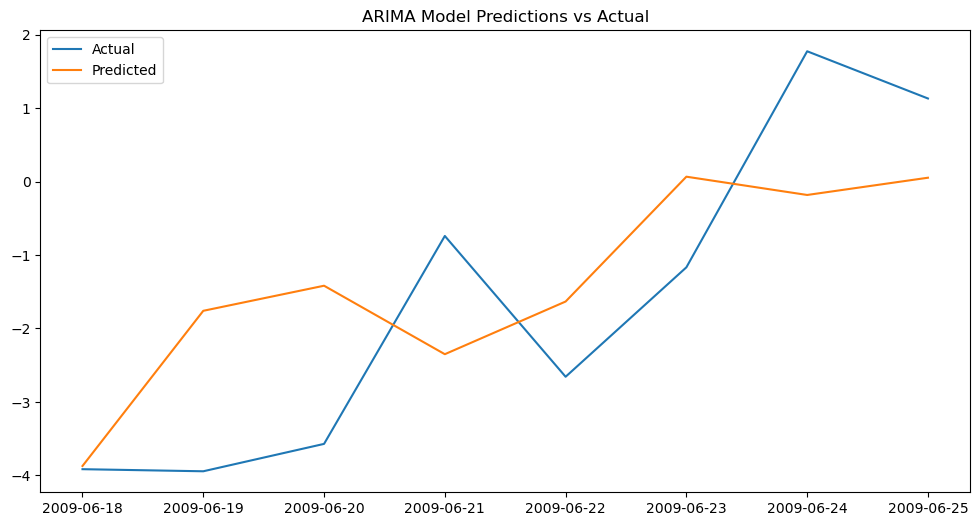

MSE: 2.4444846208292175
RMSE: 1.5634847683393713
MAE: 1.4102079214022694


In [101]:
# Fit an ARIMA(1,1,7) model based on Grid search with AIC.
model = ARIMA(train, order=(1, 1, 7))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

                               SARIMAX Results                                
Dep. Variable:       power_sentiments   No. Observations:                   66
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 -71.847
Date:                Thu, 16 Nov 2023   AIC                            155.693
Time:                        17:06:04   BIC                            168.831
Sample:                    04-13-2009   HQIC                           160.885
                         - 06-17-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0611      0.358     -0.170      0.865      -0.764       0.641
ar.L1         -0.0419      0.148     -0.284      0.776      -0.331       0.247
ar.L2          0.7096      0.140      5.061      0.0

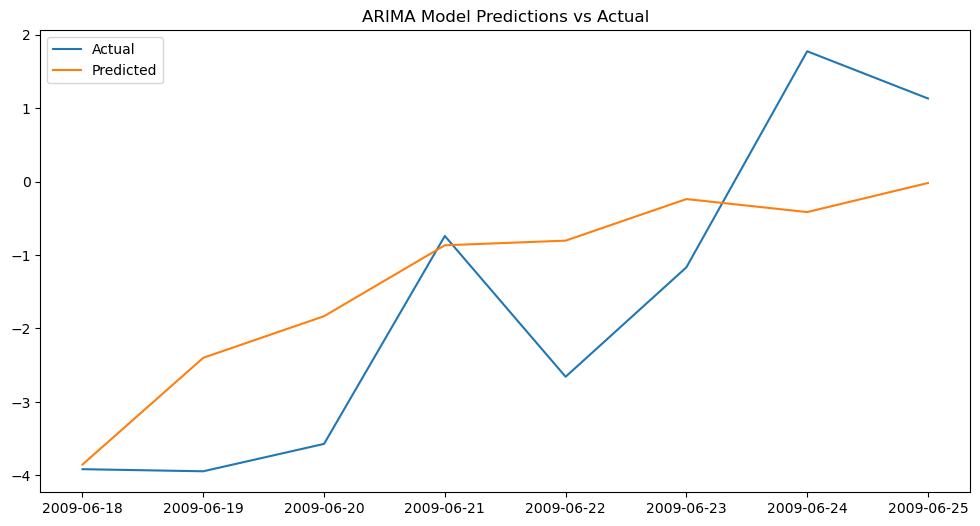

MSE: 1.9794872223596038
RMSE: 1.406942508548094
MAE: 1.1991886489287502


In [140]:
# Fit an ARIMA(5,1,1) model based on Grid search with MSE.
model = ARIMA(train, order=(3, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

- The results of the ARIMA model based on MSE and AIC criteria shows that the order of (3, 0 ,1) yield the best performance. 
1. MSE: 1.98
2. AIC: 155.69

#### ARIMA Residuals

In [131]:
# Get the residuals of the model for analysis.
residuals_arima = model_fit.resid

In [132]:
# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(residuals_arima)
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'Shapiro-Wilk test p-value: {shapiro_pvalue}')

Shapiro-Wilk test statistic: 0.9197254776954651
Shapiro-Wilk test p-value: 0.0003908170619979501


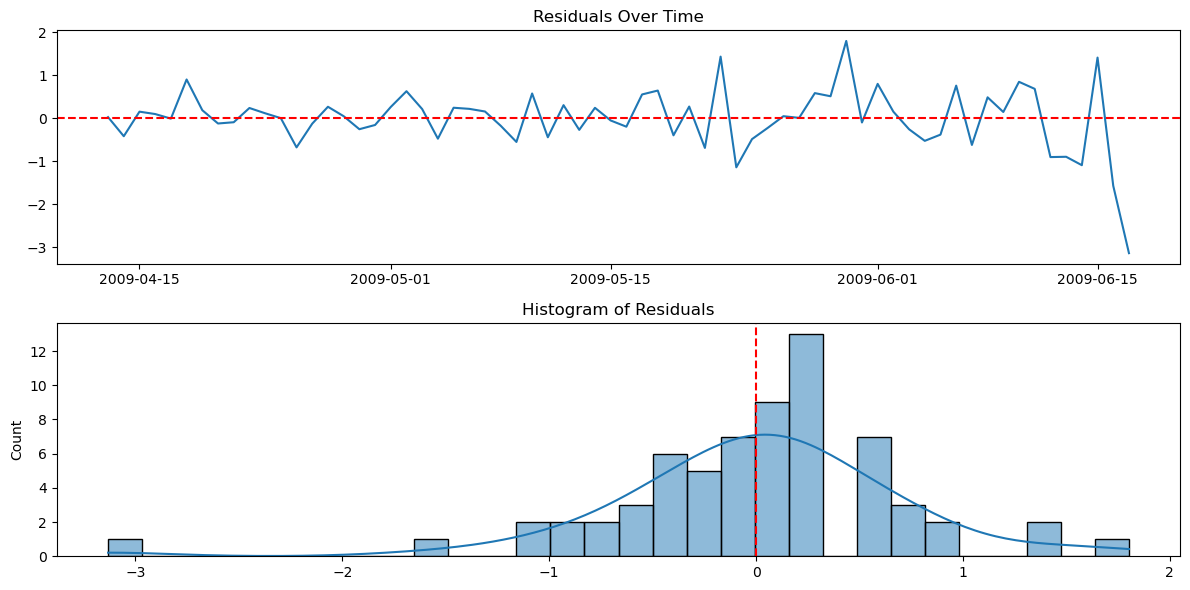

In [133]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title('Residuals Over Time')
plt.plot(residuals_arima)
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(212)
plt.title('Histogram of Residuals')
sns.histplot(residuals_arima, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

### SARIMA

In [153]:
# By appling the auto-arima with wweekly seasonality it yielded the lower AIC's.

# Fit the auto_arima model, which will automatically discover the optimal order
model = pm.auto_arima(df7, 
                      start_p=1, start_q=1, 
                      max_p=7, max_q=7, max_d=7,
                      start_P=0, start_Q=0, 
                      max_P=7, max_Q=7, max_D=7,
                      m=7,  # Weekly seasonality
                      seasonal=True, 
                      stepwise=True, 
                      suppress_warnings=True, 
                      error_action="ignore", 
                      trace=True)

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=198.783, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=247.025, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=173.985, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=245.494, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=197.143, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=175.743, Time=0.38 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=168.654, Time=0.29 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=172.221, Time=0.65 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=167.790, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=198.662, Time=0.11 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=169.789, Time=0.71 se

In [187]:
# Define the parameter ranges, used a smaller range for computational efficiency.
p = d = q = range(0, 3)  # Non-seasonal parameters
P = D = Q = range(0, 3)  # Seasonal parameters
s = 7  # Seasonal period 

# Create a list to store the top 10 models based on MSE
top_models = []

# Loop over all possible parameter combinations
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=seasonal_order + (s,),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            # Make predictions for the validation period
            predictions = model_fit.get_forecast(steps=len(test)).predicted_mean
            mse = mean_squared_error(test, predictions)
            
            # Add the model's order and MSE to the list
            top_models.append((order, seasonal_order + (s,), mse))
            
        except Exception as e:
            continue

# Sort the models by MSE, ascending, and keep the top 10
top_models.sort(key=lambda x: x[2])
top_10_models = top_models[:10]

# Print the top 10 models
for i, model_info in enumerate(top_10_models):
    print(f'Model {i+1}: Order={model_info[0]}, Seasonal Order={model_info[1]}, MSE={model_info[2]}')


Model 1: Order=(2, 1, 1), Seasonal Order=(1, 0, 2, 7), MSE=0.8909550648828692
Model 2: Order=(2, 1, 1), Seasonal Order=(2, 0, 2, 7), MSE=0.9244100044012996
Model 3: Order=(2, 1, 2), Seasonal Order=(1, 0, 2, 7), MSE=0.951116505066199
Model 4: Order=(2, 1, 0), Seasonal Order=(2, 0, 2, 7), MSE=0.9692052343587283
Model 5: Order=(2, 1, 0), Seasonal Order=(1, 0, 2, 7), MSE=0.9742444722865622
Model 6: Order=(0, 1, 1), Seasonal Order=(1, 0, 2, 7), MSE=0.9922563859447604
Model 7: Order=(1, 1, 2), Seasonal Order=(1, 0, 2, 7), MSE=0.993121990545306
Model 8: Order=(1, 1, 1), Seasonal Order=(1, 0, 2, 7), MSE=0.9997450098646571
Model 9: Order=(0, 1, 2), Seasonal Order=(1, 0, 2, 7), MSE=1.0015042398479372
Model 10: Order=(2, 1, 2), Seasonal Order=(2, 0, 2, 7), MSE=1.019715961453858


                                         SARIMAX Results                                         
Dep. Variable:                          power_sentiments   No. Observations:                   66
Model:             SARIMAX(2, 0, 2)x(3, 0, [1, 2, 3], 7)   Log Likelihood                 -68.587
Date:                                   Thu, 16 Nov 2023   AIC                            159.175
Time:                                           19:01:36   BIC                            183.261
Sample:                                       04-13-2009   HQIC                           168.692
                                            - 06-17-2009                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2078    187.129      0.001      0.999    

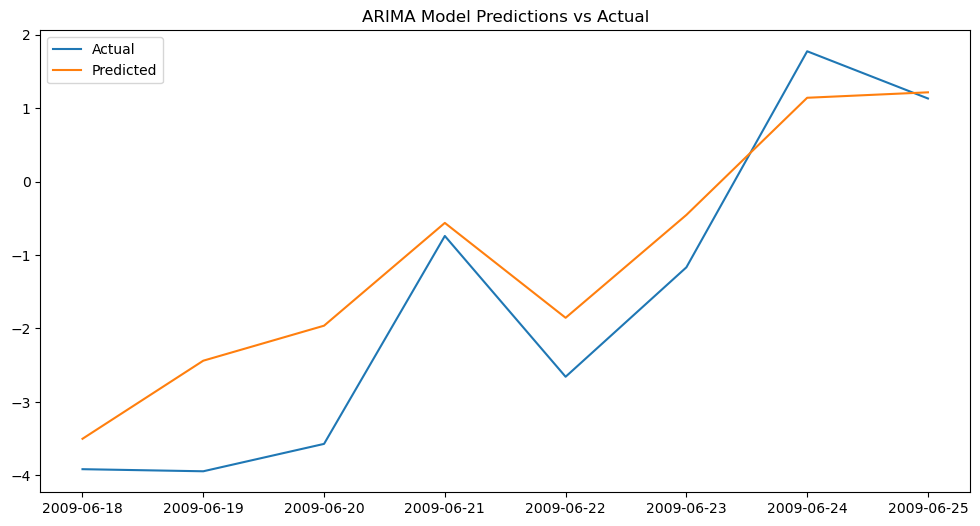

MSE: 0.8271132089617536
RMSE: 0.9094576455018417
MAE: 0.7422554813291067


In [220]:
# Fit an ARIMA(5,1,1) model based on Grid search with MSE.
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(3, 0, 3, 7))
sarima = model.fit(disp=False)

# Summary of the model
print(sarima.summary())

# Make predictions
predictions = sarima.predict(start=len(train), end=len(train) + len(test) - 1)

# Plot the actual values vs. the predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

# Calculate and print out the error metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In the SARIMA approach, the model was tested many times, using the parameters from auto_arima and grid search as starting point. And by using the grid search as reference, the parameters order that results in optimal balance between  the metrics is the (2, 0, 2)(3, 0, 3, 7). 
- MSE: 0.827
- AIC: 159.17

### Forecasting - 1 Week - 1 Month - 3 Months

In [221]:
# Forecast for one week
forecast_one_week = sarima.get_forecast(steps=7).predicted_mean
print("One Week Forecast:", forecast_one_week)

One Week Forecast: 2009-06-18   -3.501326
2009-06-19   -2.438486
2009-06-20   -1.962033
2009-06-21   -0.562970
2009-06-22   -1.854561
2009-06-23   -0.454351
2009-06-24    1.140316
Freq: D, Name: predicted_mean, dtype: float64


In [222]:
# Forecast for one month
forecast_one_month = sarima.get_forecast(steps=30).predicted_mean
print("One Month Forecast:", forecast_one_month)

One Month Forecast: 2009-06-18   -3.501326
2009-06-19   -2.438486
2009-06-20   -1.962033
2009-06-21   -0.562970
2009-06-22   -1.854561
2009-06-23   -0.454351
2009-06-24    1.140316
2009-06-25    1.214386
2009-06-26    0.692426
2009-06-27    0.409408
2009-06-28    0.129756
2009-06-29    0.373789
2009-06-30   -0.024043
2009-07-01   -0.465161
2009-07-02   -0.717516
2009-07-03   -0.321754
2009-07-04    0.003151
2009-07-05    0.558977
2009-07-06   -0.178844
2009-07-07    0.381212
2009-07-08    1.231864
2009-07-09    1.112116
2009-07-10    0.741920
2009-07-11    0.280028
2009-07-12   -0.070810
2009-07-13    0.198505
2009-07-14   -0.087355
2009-07-15   -0.643616
2009-07-16   -0.540295
2009-07-17   -0.354513
Freq: D, Name: predicted_mean, dtype: float64


In [223]:
# Forecast for three months
forecast_three_months = sarima.get_forecast(steps=90).predicted_mean
print("Three Months Forecast:", forecast_three_months)

Three Months Forecast: 2009-06-18   -3.501326
2009-06-19   -2.438486
2009-06-20   -1.962033
2009-06-21   -0.562970
2009-06-22   -1.854561
                ...   
2009-09-11    0.261621
2009-09-12    0.097761
2009-09-13   -0.106273
2009-09-14    0.118278
2009-09-15   -0.087175
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


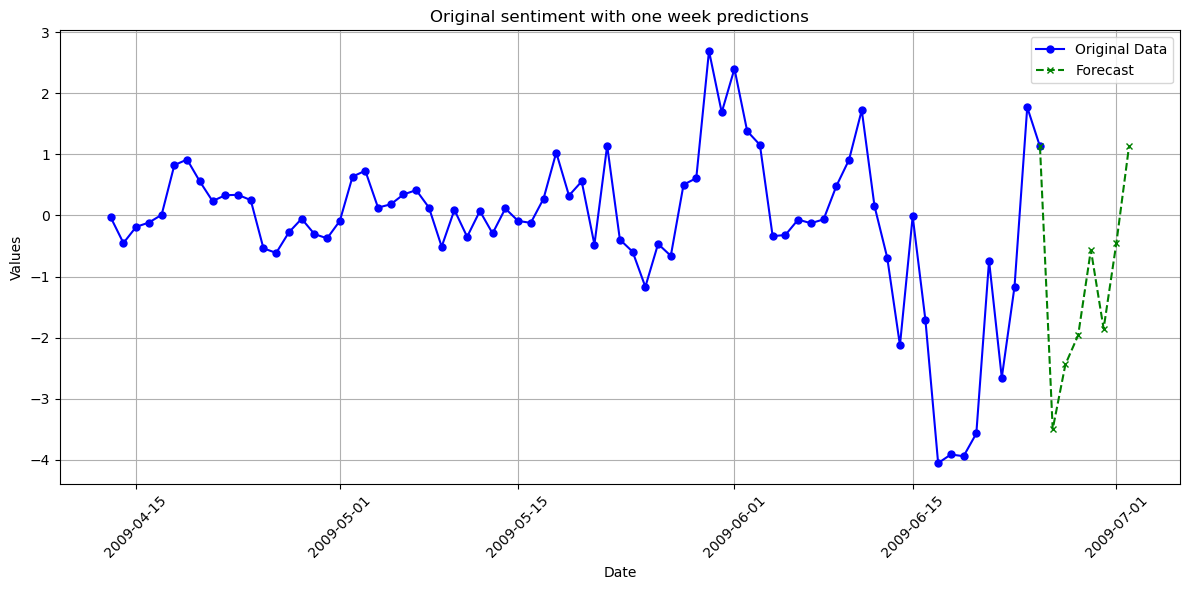

In [245]:
# Forecast for one week
forecast_one_week = sarima.get_forecast(steps=7).predicted_mean

# Plot the original and forecasted data
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(df7.index, df7, label='Original Data', marker='o', markersize=5, color='blue')

# Create a date range for the forecast
forecast_start_date = df7.index[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_one_week), freq='D')

# To create a continuous line between the historical and forecast data,
last_actual_value = df7.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_one_week), index=[df7.index[-1]] + list(forecast_dates))

# Plot the forecast data
plt.plot(forecast_with_last_actual.index, forecast_with_last_actual, label='Forecast', linestyle='--', marker='x', markersize=5, color='green')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Original sentiment with one week predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

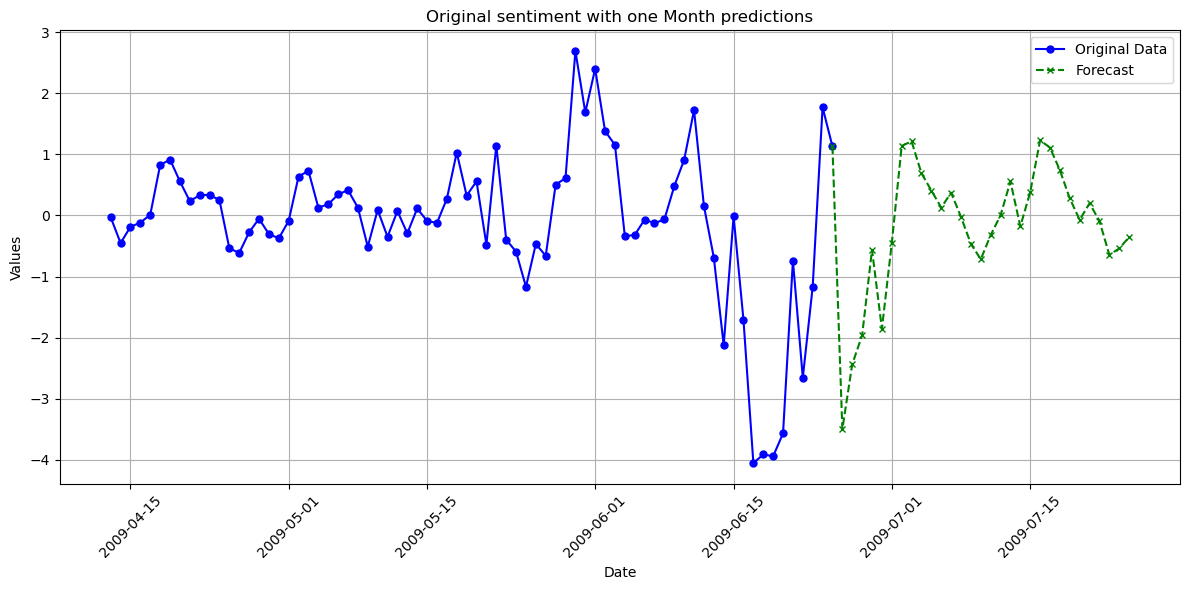

In [246]:
# Forecast for one month
forecast_one_month = sarima.get_forecast(steps=30).predicted_mean

# Plot the original and forecasted data
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(df7.index, df7, label='Original Data', marker='o', markersize=5, color='blue')

# Create a date range for the forecast
forecast_start_date = df7.index[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_one_month), freq='D')

# To create a continuous line between the historical and forecast data,
last_actual_value = df7.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_one_month), index=[df7.index[-1]] + list(forecast_dates))

# Plot the forecast data
plt.plot(forecast_with_last_actual.index, forecast_with_last_actual, label='Forecast', linestyle='--', marker='x', markersize=5, color='green')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Original sentiment with one Month predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

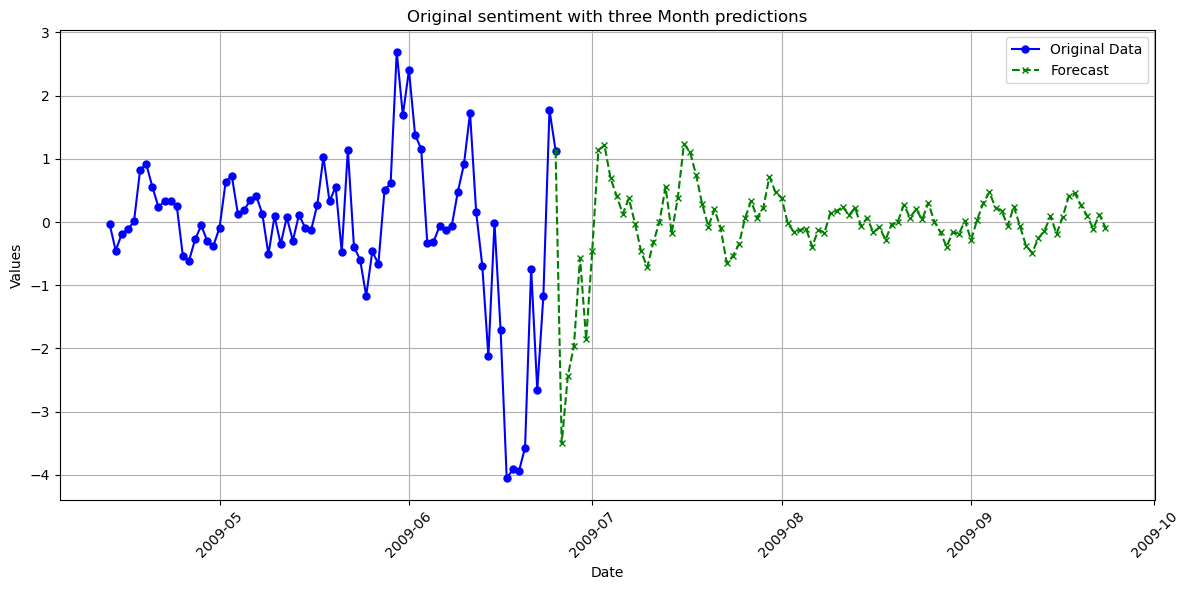

In [247]:
# Forecast for three months
forecast_three_months = sarima.get_forecast(steps=90).predicted_mean

# Plot the original and forecasted data
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(df7.index, df7, label='Original Data', marker='o', markersize=5, color='blue')

# Create a date range for the forecast
forecast_start_date = df7.index[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=len(forecast_three_months), freq='D')

# To create a continuous line between the historical and forecast data,
last_actual_value = df7.iloc[-1]
forecast_with_last_actual = pd.Series([last_actual_value] + list(forecast_three_months), index=[df7.index[-1]] + list(forecast_dates))

# Plot the forecast data
plt.plot(forecast_with_last_actual.index, forecast_with_last_actual, label='Forecast', linestyle='--', marker='x', markersize=5, color='green')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Original sentiment with three Month predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [281]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a continuous date range that includes both historical and forecast dates
last_hist_date = df7.index[-1]
forecast_dates = pd.date_range(start=last_hist_date, periods=91, freq='D')[1:]
forecast_values = forecast_three_months.values

# Combine historical and forecast data into one series for plotting
combined_dates = df7.index.append(forecast_dates)
combined_values = df7.values.tolist() + forecast_values.tolist()

# Create figure
fig = go.Figure()

# Add combined historical and forecast data trace
fig.add_trace(
    go.Scatter(
        x=combined_dates, y=combined_values, name="Historical and Forecast Data",
        mode='lines+markers',
        marker=dict(color=['blue' if val > 0 else 'red' for val in combined_values],  # Color change based on value
        size=5),  # Smaller marker size
        hoverinfo='text',  # Custom hover text
        text=[f'{date.strftime("%Y-%m-%d")}<br>{val:.2f}' for date, val in zip(combined_dates, combined_values)],  # Date and value
    )
)

# Update layout for a clean look
fig.update_layout(
    title="Interactive Forecast Plot",
    xaxis_title="Date",
    yaxis_title="Values",
    legend_title="Legend",
    hovermode="closest",  # Show hover for the closest point
    plot_bgcolor='white',  # White background
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=12, label="1m", step="month", stepmode="backward"),
                dict(count=4, label="3m", step="month", stepmode="backward"),
                dict(count=2, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date",
        range=[combined_dates.min(), combined_dates.max()]
    ),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

# Show plot
fig.show()

In [278]:
# Create a frame for each timestep
frames = [go.Frame(
    data=[go.Scatter(x=df7.index[:k+1], y=df7[:k+1])],
    name=str(k)
) for k in range(len(df7))]

fig.frames = frames

# Add play and pause buttons
play_button = dict(
    label="Play",
    method="animate",
    args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]
)

pause_button = dict(
    label="Pause",
    method="animate",
    args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]
)

fig.update_layout(
    updatemenus=[dict(type="buttons", showactive=False, buttons=[play_button, pause_button])]
)

# Show plot with animation
fig.show()

In [286]:
# Calculate metrics for one week forecast
avg_week = forecast_one_week.mean()
min_week = forecast_one_week.min()
max_week = forecast_one_week.max()

# Calculate metrics for one month forecast
avg_month = forecast_one_month.mean()
min_month = forecast_one_month.min()
max_month = forecast_one_month.max()

# Calculate metrics for three months forecast
avg_three_months = forecast_three_months.mean()
min_three_months = forecast_three_months.min()
max_three_months = forecast_three_months.max()

In [ ]:
AAA

In [ ]:
df.unpersist()

In [ ]:
# Write the DataFrame to a CSV file in the local file system of the Spark driver node
df.write.csv('file:///home/hduser/Desktop/CA2/pro_tweets.csv', header=True)